# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

RANDOM_STATE = 42

# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [3]:
def load_parquet_file(filename, base_url="https://storage.yandexcloud.net/mle-data/ym/"):
    """
    Универсальная функция для загрузки parquet файлов.
    
    Args:
        filename (str): Имя файла для загрузки (например, "tracks.parquet")
        base_url (str): Базовый URL для скачивания файлов
    
    Returns:
        pd.DataFrame или None: Загруженные данные или None при ошибке
    """
    # Формируем полный URL
    file_url = f"{base_url}{filename}"
    
    try:
        data = pd.read_parquet(filename)
        print(f"{filename} загружен локально")
        return data
        
    except FileNotFoundError:
        print(f"{filename} не найден, скачиваю из {file_url}...")
        try:
            subprocess.run(['wget', file_url], check=True)
            data = pd.read_parquet(filename)
            print(f"{filename} успешно скачан и загружен")
            return data
        except subprocess.CalledProcessError:
            print(f"Ошибка при скачивании {filename}")
            return None
        except Exception as e:
            print(f"Ошибка при чтении скачанного {filename}: {e}")
            return None
    except Exception as e:
        print(f"Ошибка при чтении {filename}: {e}")
        return None

In [4]:
# Использование функции
tracks = load_parquet_file("tracks.parquet")
catalog_names = load_parquet_file("catalog_names.parquet")
interactions = load_parquet_file("interactions.parquet")

tracks.parquet загружен локально
catalog_names.parquet загружен локально
interactions.parquet загружен локально


In [5]:
# Проверяем загрузку
if all(x is not None for x in [tracks, catalog_names, interactions]):
    print("✓ Все файлы успешно загружены!")
    print(f"Tracks: {tracks.shape}")
    print(f"Catalog names: {catalog_names.shape}")
    print(f"Interactions: {interactions.shape}")
else:
    print("⚠ Не все файлы удалось загрузить")

✓ Все файлы успешно загружены!
Tracks: (1000000, 4)
Catalog names: (1812471, 3)
Interactions: (222629898, 4)


# Обзор данных

tracks.parquet - данные о треках:  
 - track_id — идентификатор музыкального трека;  
 - albums —  список идентификаторов альбомов, содержащих трек;  
 - artists — список идентификаторов исполнителей трека;  
 - genres — список идентификаторов жанров, к которым принадлежит трек.

In [6]:
tracks.head()

,track_id,albums,artists,genres
0,26,"[3, 2490753]",[16],"[11, 21]"
1,38,"[3, 2490753]",[16],"[11, 21]"
2,135,"[12, 214, 2490809]",[84],[11]
3,136,"[12, 214, 2490809]",[84],[11]
4,138,"[12, 214, 322, 72275, 72292, 91199, 213505, 24...",[84],[11]


In [7]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   track_id  1000000 non-null  int64 
 1   albums    1000000 non-null  object
 2   artists   1000000 non-null  object
 3   genres    1000000 non-null  object
dtypes: int64(1), object(3)
memory usage: 30.5+ MB


In [8]:
is_unique = tracks['track_id'].nunique() == len(tracks)
unique_count = tracks['track_id'].nunique()
total_count = len(tracks)

print(f" Уникальность значений:")
print("=" * 40)
print(f"   • Всего записей: {total_count:,}")
print(f"   • Уникальных track_id: {unique_count:,}")
print(f"   • Все track_id уникальны: {'ДА' if is_unique else 'НЕТ'}")
if not is_unique:
    duplicates = total_count - unique_count
    print(f"   • Дубликатов найдено: {duplicates:,}")

 Уникальность значений:
   • Всего записей: 1,000,000
   • Уникальных track_id: 1,000,000
   • Все track_id уникальны: ДА


In [9]:
tracks[tracks["albums"].str.len() == 0]

,track_id,albums,artists,genres
310821,20200372,[],[],[]
310826,20200380,[],[],[]
312469,20305116,[],[],[]
312474,20305121,[],[],[]
320353,20756854,[],[],[]
326588,21196099,[],[],[]
326592,21196103,[],[],[]
326594,21196105,[],[],[]
326596,21196107,[],[],[]
326598,21196109,[],[],[]


есть небольшое кол-во пустых списков идентификаторов альбомов (с пустыми для них идентификаторами исполнителей трека и жанров)

In [10]:
def check_empty_lists(df, column_name, entity_name=None):
    """
    Проверяет колонку с списками на пустые значения
    
    Parameters:
    df - DataFrame для анализа
    column_name - название колонки со списками
    entity_name - человекочитаемое название сущности (опционально)
    """
    
    # Подсчитываем пустые списки
    empty_mask = df[column_name].str.len() == 0
    count_empty = empty_mask.sum()
    total_count = len(df)
    
    print(f"Записей с пустыми {entity_name}: {count_empty:,}")
    print(f"Процент от общего числа: {count_empty/total_count*100:.4f}%")
    print(f"Всего записей: {total_count:,}")
    print(f"Записей с {entity_name}: {total_count - count_empty:,}")
    print("=" * 45)
    
    if count_empty > 0:
        # Получаем примеры ID с пустыми списками
        if 'track_id' in df.columns:
            sample_ids = df.loc[empty_mask, 'track_id'].head(5).tolist()
            print(f"\n Примеры track_id с пустыми {entity_name}:")
            for track_id in sample_ids:
                print(f"   • {track_id}")
        else:
            # Если нет track_id, показываем индексы
            sample_indices = df[empty_mask].index[:5].tolist()
            print(f"\n Примеры индексов с пустыми {entity_name}:")
            for idx in sample_indices:
                print(f"   • Индекс: {idx}")
    
    print("=" * 45)
    return empty_mask

In [11]:
def remove_empty_lists_column(df, column_name, entity_name=None):
    """
    Удаляет записи с пустыми списками в указанном столбце
    
    Parameters:
    df - DataFrame для обработки
    column_name - название столбца со списками
    entity_name - человекочитаемое название сущности
    """
    
    if entity_name is None:
        entity_name = column_name
    
    print(f"УДАЛЕНИЕ ЗАПИСЕЙ БЕЗ {entity_name.upper()}")
    print("=" * 45)
    
    # Сохраняем исходное количество
    initial_count = len(df)
    
    # Находим track_id для удаления
    track_id_to_delete = df[df[column_name].str.len() == 0]["track_id"]
    
    # Удаляем записи
    df_cleaned = df[~df["track_id"].isin(track_id_to_delete)]
    final_count = len(df_cleaned)
    
    print(f"Удалено треков: {initial_count - final_count:,}")
    print(f"Осталось треков: {final_count:,}")
    print("=" * 45)
    
    return df_cleaned, track_id_to_delete.tolist()

In [12]:
albums_result = check_empty_lists(tracks, 'albums', 'альбомами')

Записей с пустыми альбомами: 18
Процент от общего числа: 0.0018%
Всего записей: 1,000,000
Записей с альбомами: 999,982

 Примеры track_id с пустыми альбомами:
   • 20200372
   • 20200380
   • 20305116
   • 20305121
   • 20756854


In [13]:
# Удаляем треки без альбомов
tracks, deleted_albums = remove_empty_lists_column(tracks, "albums", "альбомов")

УДАЛЕНИЕ ЗАПИСЕЙ БЕЗ АЛЬБОМОВ
Удалено треков: 18
Осталось треков: 999,982


In [14]:
artists_result = check_empty_lists(tracks, 'artists', 'артистами')

Записей с пустыми артистами: 15,351
Процент от общего числа: 1.5351%
Всего записей: 999,982
Записей с артистами: 984,631

 Примеры track_id с пустыми артистами:
   • 3599314
   • 3599591
   • 4790215
   • 10063296
   • 12122918


In [15]:
# Удаляем треки без артистов
tracks, deleted_artists = remove_empty_lists_column(tracks, "artists", "артистов")

УДАЛЕНИЕ ЗАПИСЕЙ БЕЗ АРТИСТОВ
Удалено треков: 15,351
Осталось треков: 984,631


In [16]:
genres_result = check_empty_lists(tracks, 'genres', 'жанрами')

Записей с пустыми жанрами: 3,654
Процент от общего числа: 0.3711%
Всего записей: 984,631
Записей с жанрами: 980,977

 Примеры track_id с пустыми жанрами:
   • 2520
   • 16776
   • 16801
   • 23752
   • 38012


In [17]:
tracks, deleted_genres = remove_empty_lists_column(tracks, "genres", "жанров")

УДАЛЕНИЕ ЗАПИСЕЙ БЕЗ ЖАНРОВ
Удалено треков: 3,654
Осталось треков: 980,977


In [18]:
# Объединяем все списки удаленных треков
track_id_deleted = deleted_albums + deleted_artists + deleted_genres

print(" СТАТИСТИКА УДАЛЕННЫХ ТРЕКОВ")
print("=" * 40)

# Подсчитываем общую статистику
total_deleted = len(track_id_deleted)
unique_deleted = len(set(track_id_deleted))

print(f"Всего удалено записей: {total_deleted:,}")
print(f"Уникальных track_id: {unique_deleted:,}")

# Статистика по исходным данным
initial_count = unique_count  # Замените на ваше исходное количество
remaining_count = unique_count - unique_deleted

print(f"\n ОБЩАЯ СТАТИСТИКА:")
print("=" * 40)
print(f"Исходное количество треков: {unique_count:,}")
print(f"Удалено уникальных треков: {unique_deleted:,}")
print(f"Осталось треков: {remaining_count:,}")
print(f"Процент удаленных: {unique_deleted*100/initial_count:.2f}%")

 СТАТИСТИКА УДАЛЕННЫХ ТРЕКОВ
Всего удалено записей: 19,023
Уникальных track_id: 19,023

 ОБЩАЯ СТАТИСТИКА:
Исходное количество треков: 1,000,000
Удалено уникальных треков: 19,023
Осталось треков: 980,977
Процент удаленных: 1.90%


In [19]:
# Сохраняем список в CSV
deleted_df = pd.DataFrame({'deleted_track_id': track_id_deleted})
deleted_df.to_csv('deleted_tracks.csv', index=False)

print(f"Список из {len(track_id_deleted):,} track_id сохранен в 'deleted_tracks.csv'")

Список из 19,023 track_id сохранен в 'deleted_tracks.csv'


In [20]:
# Преобразуем track_id из int64 в int32
tracks['track_id'] = tracks['track_id'].astype('int32')

# Проверим результат
print(f"Новый тип track_id: {tracks['track_id'].dtype}")
print(f"Память после преобразования:")
tracks.info()

Новый тип track_id: int32
Память после преобразования:
<class 'pandas.core.frame.DataFrame'>
Index: 980977 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   track_id  980977 non-null  int32 
 1   albums    980977 non-null  object
 2   artists   980977 non-null  object
 3   genres    980977 non-null  object
dtypes: int32(1), object(3)
memory usage: 33.7+ MB


In [21]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 980977 entries, 0 to 999999
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   track_id  980977 non-null  int32 
 1   albums    980977 non-null  object
 2   artists   980977 non-null  object
 3   genres    980977 non-null  object
dtypes: int32(1), object(3)
memory usage: 33.7+ MB


_______________________________________________

catalog_names.parquet - имена артистов, названия альбомов, треков и жанров:  
 - id — идентификатор одной из каталожных единиц (трека, альбома, исполнителя, жанра);  
 - type — тип идентификатора;  
 - name — имя (название) каталожной единицы.

In [22]:
catalog_names.head()

,id,type,name
0,3,album,Taller Children
1,12,album,Wild Young Hearts
2,13,album,Lonesome Crow
3,17,album,Graffiti Soul
4,26,album,Blues Six Pack


In [23]:
catalog_names.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1812471 entries, 0 to 1812470
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   id      int64 
 1   type    object
 2   name    object
dtypes: int64(1), object(2)
memory usage: 41.5+ MB


In [24]:
catalog_names["type"].value_counts()
# в каталоге больше всего треков, затем альбомы, артисты и жанры 

type
track     1000000
album      658724
artist     153581
genre         166
Name: count, dtype: int64

In [25]:
catalog_name_id_dubl = len(catalog_names) - catalog_names["id"].nunique()

print(f"Исходное количество `id`: {len(catalog_names):,}")
print(f"Уникальных `id`: {catalog_names['id'].nunique():,}")
print(f"Дубликаты: {catalog_name_id_dubl:,}")

Исходное количество `id`: 1,812,471
Уникальных `id`: 1,776,697
Дубликаты: 35,774


In [26]:
catalog_names[catalog_names['id'].duplicated()]

,id,type,name
658728,12,artist,Phil Everly
658735,34,artist,Miles Davis
658736,36,artist,Baker
658741,87,artist,Michael Schenker
658744,93,artist,Femi Kuti
...,...,...,...
1141043,21314698,track,No Good For You
1141108,21320653,track,Oh!
1141114,21321251,track,Lady in Red
1141142,21327491,track,Waiting Here


In [27]:
catalog_names[catalog_names["id"] == 87]

,id,type,name
25,87,album,Chronicle: 20 Greatest Hits
658741,87,artist,Michael Schenker
812392,87,genre,religion


Идентификаторы `id` для разных типов могут повторяться.

In [28]:
catalog_name_name_dubl = len(catalog_names) - catalog_names["name"].nunique()

print(f"Исходное количество `name`: {len(catalog_names):,}")
print(f"Уникальных `name`: {catalog_names['name'].nunique():,}")
print(f"Дубликаты: {catalog_name_name_dubl:,}")

Исходное количество `name`: 1,812,471
Уникальных `name`: 945,118
Дубликаты: 867,353


есть дубликаты по имени (названию) каталожной единицы. - 867353 из 1812471

In [29]:
catalog_names_t_n_dubl = catalog_names[catalog_names['name'].duplicated()]
catalog_names_t_n_dubl

,id,type,name
10,43,album,Blues Six Pack
11,45,album,Blues Six Pack
13,49,album,Graffiti Soul
28,94,album,Jazz Six Pack
29,95,album,Blues Six Pack
...,...,...,...
1812466,101478482,track,На лицо
1812467,101490148,track,Без капли мысли
1812468,101493057,track,SKITTLES
1812469,101495927,track,Москва


In [30]:
catalog_names[catalog_names["name"] == "Blues Six Pack"]

,id,type,name
4,26,album,Blues Six Pack
10,43,album,Blues Six Pack
11,45,album,Blues Six Pack
29,95,album,Blues Six Pack
34519,91414,album,Blues Six Pack


под разными идентификаторами в каталоге имеются одни и те же альбомы

In [31]:
# удаляем такие дубли оставив первый
catalog_names_clean = catalog_names.drop_duplicates(subset=["type","name"], keep="first")

print(f"\n ОБЩАЯ СТАТИСТИКА:")
print("=" * 40)
print(f"Исходное количество записей: {len(catalog_names):,}")
print(f"Удалено дублированных записей: {len(catalog_names) - len(catalog_names_clean):,}")
print(f"Осталось записей: {len(catalog_names_clean):,}")
print(f"Процент оставшихся записей: {len(catalog_names_clean)*100/len(catalog_names):.2f}%")


 ОБЩАЯ СТАТИСТИКА:
Исходное количество записей: 1,812,471
Удалено дублированных записей: 689,769
Осталось записей: 1,122,702
Процент оставшихся записей: 61.94%


In [32]:
catalog_names_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1122702 entries, 0 to 1812468
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   id      1122702 non-null  int64 
 1   type    1122702 non-null  object
 2   name    1122702 non-null  object
dtypes: int64(1), object(2)
memory usage: 34.3+ MB


In [33]:
# уберем из данных треки из списка track_id_deleted
catalog_names_clean_tracks = catalog_names_clean[catalog_names_clean["type"]=="track"]
catalog_names_clean_others = catalog_names_clean[catalog_names_clean["type"]!="track"]
catalog_names_clean_tracks = catalog_names_clean_tracks[~catalog_names_clean_tracks["id"].isin(track_id_deleted)]
catalog_names_clean = pd.concat([catalog_names_clean_others,catalog_names_clean_tracks],ignore_index=True)

print(f"\n ИТОГОАЯ СТАТИСТИКА:")
print("=" * 40)
print(f"Исходное количество записей: {len(catalog_names):,}")
print(f"Удалено дублированных записей: {len(catalog_names) - len(catalog_names_clean):,}")
print(f"Удалено треков: {len(track_id_deleted):,}")
print(f"Осталось записей: {len(catalog_names_clean):,}")
print(f"Процент оставшихся записей: {len(catalog_names_clean)*100/len(catalog_names):.2f}%")


 ИТОГОАЯ СТАТИСТИКА:
Исходное количество записей: 1,812,471
Удалено дублированных записей: 706,682
Удалено треков: 19,023
Осталось записей: 1,105,789
Процент оставшихся записей: 61.01%


In [34]:
catalog_names_clean.sort_values(by = "name")
# в именах (названиях) каталожных единиц присутсвуют эмодзи, символы ASCII, либо только знаки препинания.
# фильтровать такие значения тяжело, пока оставим как есть, но будем иметь ввиду

,id,type,name
575388,8865715,artist,\tDrake
670765,1710520,track,!
102514,2081150,album,!
567666,7709071,artist,!
32780,169465,album,! (Знак оклику)
...,...,...,...
390658,14512698,album,💗 Pop y Amor 💗
389309,14404588,album,📚 Música Para Leer 📚
386736,14157216,album,🔥 Regeton Viejito Vol.2 🔥
389388,14405050,album,🚗 Para que te sientas en Camioneta Roja 🚗


In [35]:
import re
import pandas as pd

def clean_text(text):
    if pd.isna(text):
        return text
    
    # Удаляем эмодзи и специальные символы
    text = re.sub(r'[^\w\sа-яА-Яa-zA-Z0-9]', ' ', str(text))
    
    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Применяем функцию к столбцу
catalog_names_clean2 = catalog_names_clean.copy()
catalog_names_clean2['name_clean'] = catalog_names_clean2['name'].apply(clean_text)

In [36]:
catalog_names_clean2.sort_values(by = "name")

,id,type,name,name_clean
575388,8865715,artist,\tDrake,Drake
670765,1710520,track,!,
102514,2081150,album,!,
567666,7709071,artist,!,
32780,169465,album,! (Знак оклику),Знак оклику
...,...,...,...,...
390658,14512698,album,💗 Pop y Amor 💗,Pop y Amor
389309,14404588,album,📚 Música Para Leer 📚,Música Para Leer
386736,14157216,album,🔥 Regeton Viejito Vol.2 🔥,Regeton Viejito Vol 2
389388,14405050,album,🚗 Para que te sientas en Camioneta Roja 🚗,Para que te sientas en Camioneta Roja


In [37]:
# Находим записи, которые после очистки стали пустыми или слишком короткими
empty_names = catalog_names_clean2[
    (catalog_names_clean2['name_clean'].str.len() < 2) | 
    (catalog_names_clean2['name_clean'].isna())
]

print(f"Записей с невалидными названиями: {len(empty_names)}")
print(f"Всего записей: {len(catalog_names_clean2)}")
print(f"Процент записей к удалению: {len(empty_names)*100/len(catalog_names_clean2):.2f}%")

Записей с невалидными названиями: 384
Всего записей: 1105789
Процент записей к удалению: 0.03%


In [38]:
# Удаляем из основного DataFrame записи с индексами из empty_names
catalog_names_clean2 = catalog_names_clean2.drop(empty_names.index)

print(f"Удалено записей: {len(empty_names)}")
print(f"Осталось записей: {len(catalog_names_clean2)}")

Удалено записей: 384
Осталось записей: 1105405


In [39]:
catalog_names_clean2.sort_values(by = "name")

,id,type,name,name_clean
575388,8865715,artist,\tDrake,Drake
32780,169465,album,! (Знак оклику),Знак оклику
670763,1710515,track,! (С.К.А.Й. & Пікардійська Терція),С К А Й Пікардійська Терція
783780,19775700,track,"! Cat Meow Meow, #1 You Are My Sunshine (feat....",Cat Meow Meow 1 You Are My Sunshine feat Fun K...
107427,2228200,album,"! Cat Meow Meow, #1 You Are My Sunshine (feat....",Cat Meow Meow 1 You Are My Sunshine feat Fun K...
...,...,...,...,...
390658,14512698,album,💗 Pop y Amor 💗,Pop y Amor
389309,14404588,album,📚 Música Para Leer 📚,Música Para Leer
386736,14157216,album,🔥 Regeton Viejito Vol.2 🔥,Regeton Viejito Vol 2
389388,14405050,album,🚗 Para que te sientas en Camioneta Roja 🚗,Para que te sientas en Camioneta Roja


In [40]:
# Удаляем исходную колонку name и переименовываем clean_name
catalog_names_clean2 = catalog_names_clean2.drop(columns=['name']).rename(columns={'name_clean': 'name'})

In [41]:
# Проверяем результат
print("\nПервые 15 записей после очистки:")
print(catalog_names_clean2.head(15))


Первые 15 записей после очистки:
    id   type                                               name
0    3  album                                    Taller Children
1   12  album                                  Wild Young Hearts
2   13  album                                      Lonesome Crow
3   17  album                                      Graffiti Soul
4   26  album                                     Blues Six Pack
5   27  album  Authorized Bootleg Live Tokyo Dome Tokyo Japan...
6   29  album                               Foot Of The Mountain
7   34  album                             Self Taught Learner EP
8   36  album                                     A Secret Place
9   39  album                                         Sunny Days
10  48  album                    THE E N D THE ENERGY NEVER DIES
11  52  album                                       Classic Rock
12  54  album                                Sides Of Blue Vol 2
13  57  album                                           

_____________________

interactions.parquet - данные о том, какие пользователи прослушали тот или иной трек:  
- user_id — идентификатор пользователя,  
- track_id — идентификатор музыкального трека,  
- track_seq — номер места трека в истории пользователя,  
- started_at — дата начала прослушивания трека.

In [42]:
interactions.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [43]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 222629898 entries, 0 to 291
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 5.4 GB


Проверяем данные, есть ли с ними явные проблемы.

In [44]:
interactions_clean = interactions[~interactions['track_id'].isin(track_id_deleted)].reset_index(drop=True)

In [45]:
# Убедимся, что теперь типы совпадают
print(f"Тип track_id в tracks: {tracks['track_id'].dtype}")
print(f"Тип track_id в interactions: {interactions_clean['track_id'].dtype}")

# Проверим, что все track_id из interactions_clean есть в tracks
missing_tracks = set(interactions_clean['track_id']) - set(tracks['track_id'])
print(f"Отсутствующих track_id в tracks: {len(missing_tracks)}")

Тип track_id в tracks: int32
Тип track_id в interactions: int32
Отсутствующих track_id в tracks: 0


In [46]:
interactions_clean["track_id"].nunique()

980977

In [47]:
len(interactions_clean)

222184449

In [48]:
print(f"Процент оставшихся: {len(interactions_clean)*100/len(interactions):.2f}%")

Процент оставшихся: 99.80%


In [49]:
interactions_clean[interactions_clean["track_seq"].isnull()]

,user_id,track_id,track_seq,started_at


пропусков по track_seq нет

In [50]:
interactions_clean["track_seq"].describe().apply(lambda x: f"{x:0.1f}")

count    222184449.0
mean           462.0
std            824.8
min              1.0
25%             56.0
50%            181.0
75%            505.0
max          16637.0
Name: track_seq, dtype: object

- max(track_seq) = 16637  
- min(track_seq) = 1  
- 75% `track_seq` меньше 506 
- на будущее: посчитать их за выбросы и удалить из данных

In [51]:
# оставим только взаимодействия с номерами места трека в истории пользователя меньше-равно 1000
interactions_clean = interactions_clean[interactions_clean["track_seq"] <= 1000].reset_index(drop=True)
interactions_clean.head()

,user_id,track_id,track_seq,started_at
0,0,99262,1,2022-07-17
1,0,589498,2,2022-07-19
2,0,590262,3,2022-07-21
3,0,590303,4,2022-07-22
4,0,590692,5,2022-07-22


In [52]:
print(f"Процент оставшихся взаимодействий: {len(interactions_clean)*100/len(interactions):.2f}%")

Процент оставшихся взаимодействий: 87.81%


In [53]:
interactions_clean[interactions_clean["started_at"].isnull()]

,user_id,track_id,track_seq,started_at


пропусков по `started_at` нет

In [54]:
interactions_clean["started_at"].describe()

count                        195486833
mean     2022-08-26 18:29:16.756822016
min                2022-01-01 00:00:00
25%                2022-06-27 00:00:00
50%                2022-09-12 00:00:00
75%                2022-11-07 00:00:00
max                2022-12-31 00:00:00
Name: started_at, dtype: object

- min(started_at) = 2022-01-01  
- max(started_at) = 2022-12-31  
- все корректно, данные датированы за весь 2022 год

In [55]:
# Пример данных по взаимодействиям:
print(interactions_clean.sample(5, random_state=RANDOM_STATE)
                        .sort_values("user_id")
                        .set_index(["user_id", "track_id"])
                        .to_string())

                  track_seq started_at
user_id track_id                      
23030   62107387         62 2022-10-10
398657  38714371        473 2022-11-01
443853  2193302          36 2022-12-06
1339870 45430540        282 2022-08-31
1363369 433550           13 2022-12-23


In [56]:
interactions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195486833 entries, 0 to 195486832
Data columns (total 4 columns):
 #   Column      Dtype         
---  ------      -----         
 0   user_id     int32         
 1   track_id    int32         
 2   track_seq   int16         
 3   started_at  datetime64[ns]
dtypes: datetime64[ns](1), int16(1), int32(2)
memory usage: 3.3 GB


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.  




Итог:  
-  в таблице `tracks` обнаружены пустые списки идентификаторов альбомов, исполнителей трека и жанров. Они были удалены. Оставшийся объем 98%. Треки были исключены из `catalog_names` и `interactions`. Тип данных в `track_id` приведен к `int32`, к такому же типу как и в `interactions`.  
-  из таблицы `catalog_names` исключены дубликаты по парам ["type","name"]. Исключили взаимодействия по удаленным трекам из tracks. В итоге осталось 61% данных. В именах (названиях) каталожных единиц присутсвуют эмодзи, символы ASCII, либо только знаки препинания. Не смотряна на их малое кол-во (Записей с невалидными названиями: 384 - Всего записей: 1105789 - Процент записей к удалению: 0.03%), попробовали их обработать.  
-  в таблице `interactions` почти 223 млн взаимодействий с менее 1% уникальных пользователей. Исключили взаимодействия по удаленным трекам из tracks, а также взаимодействия с номерами места трека в истории пользователя > 1000. В результате чего, осталось 88% взаимодействий.

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

In [57]:
# добавим колонку started_at_month - месяц взаимодействия:
interactions_clean["started_at_month"] = pd.to_datetime(interactions_clean["started_at"]).dt.month.astype('int8')

interactions_clean.head()

,user_id,track_id,track_seq,started_at,started_at_month
0,0,99262,1,2022-07-17,7
1,0,589498,2,2022-07-19,7
2,0,590262,3,2022-07-21,7
3,0,590303,4,2022-07-22,7
4,0,590692,5,2022-07-22,7


In [58]:
interactions_by_month = interactions_clean.groupby("started_at_month").agg(events=("started_at", "count"), users=("user_id", "nunique")).reset_index()
interactions_by_month

,started_at_month,events,users
0,1,2406028,126127
1,2,4405364,227693
2,3,7199997,343667
3,4,9379699,452657
4,5,12403231,566908
5,6,14672283,672069
6,7,17982750,781811
7,8,21037506,883173
8,9,23438460,966781
9,10,27321653,1039508


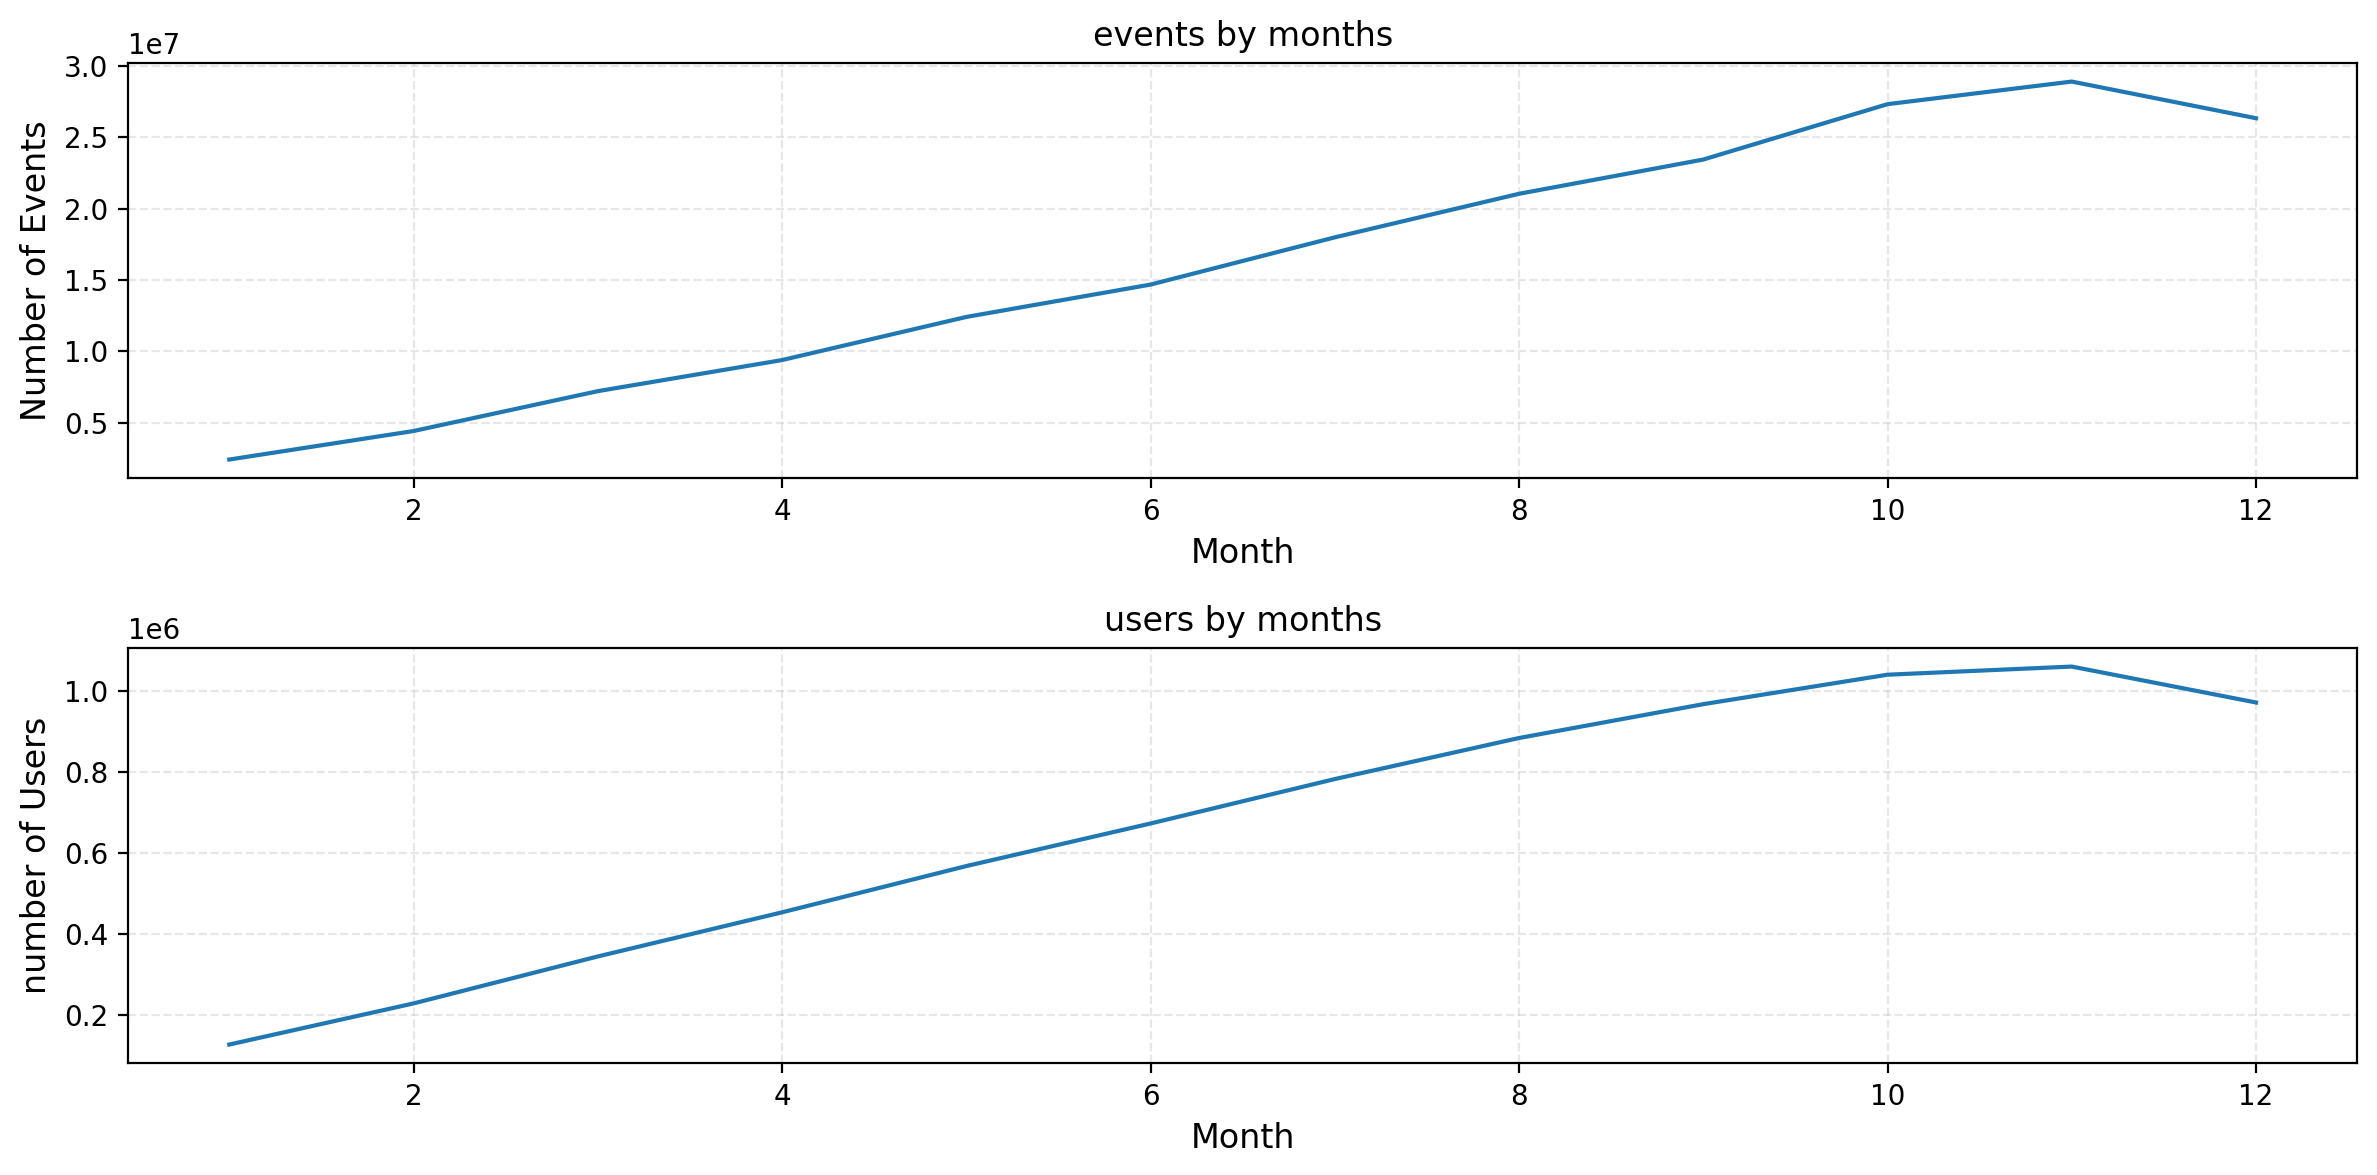

In [59]:
# распределение взаимодействий в течение года

fig, axs = plt.subplots(2, 1, figsize=(12, 6))

ax = axs[0]
ax.plot(interactions_by_month["started_at_month"], interactions_by_month["events"])
ax.set_title("events by months")
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylabel("Number of Events", fontsize=12)
ax.set_xlabel("Month", fontsize=12)

ax = axs[1]
ax.plot(interactions_by_month["started_at_month"], interactions_by_month["users"])
ax.set_title("users by months")
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylabel("number of Users", fontsize=12)
ax.set_xlabel("Month", fontsize=12)

fig.tight_layout()


популярность сервиса растет в течение года, с ноября наблюдается спад.

Наиболее популярные треки

In [60]:
# группируем по track_id и считаем кол-во уникальных пользователей, которые взаимодействовали с треком
interactions_by_track = interactions_clean.groupby("track_id").agg(users=("user_id", "nunique")).reset_index()
interactions_by_track

,track_id,users
0,26,5
1,38,8
2,135,16
3,136,7
4,138,17
...,...,...
980190,101478482,5
980191,101490148,59
980192,101493057,5
980193,101495927,17


In [61]:
# получим идентификаторы ТОП-100 треков за год
interactions_by_track_top_100 = interactions_by_track.sort_values(by="users",ascending=False).head(100).reset_index(drop=True)
interactions_by_track_top_100

,track_id,users
0,53404,111062
1,33311009,102762
2,178529,101913
3,35505245,97421
4,795836,84546
...,...,...
95,9282507,49261
96,33308946,49157
97,630670,49027
98,2192826,49016


In [62]:
# добавим идентификаторы альбомов, артистов и жанров
interactions_by_track_top_100 = interactions_by_track_top_100.merge(tracks, on="track_id", how="left")
interactions_by_track_top_100

,track_id,users,albums,artists,genres
0,53404,111062,"[4367, 89708, 294911, 294912, 294914, 297393, ...",[9262],"[13, 14, 102]"
1,33311009,102762,"[4440454, 4456609, 4482682, 4882996, 5072976, ...",[675068],"[14, 102]"
2,178529,101913,"[18113, 21924, 21940, 488052, 10009799]",[36800],"[41, 47]"
3,35505245,97421,"[4431303, 20559909]","[4611844, 588511]","[3, 75]"
4,795836,84546,"[88770, 296297, 297576, 302579, 303469, 558376...",[680],"[11, 14, 102]"
...,...,...,...,...,...
95,9282507,49261,"[979404, 16409235]",[1462419],"[2, 102]"
96,33308946,49157,[4072205],[41133],"[5, 102]"
97,630670,49027,"[62233, 67454, 67456, 73694, 73724, 73757, 737...",[64592],[50]
98,2192826,49016,"[217019, 11805582]",[41098],"[2, 102]"


Наиболее популярные жанры

In [63]:
# новые колонки - первые значения списков из albums, artists, genres
interactions_by_track_top_100["album_1"] = interactions_by_track_top_100["albums"].str[0]
interactions_by_track_top_100["artist_1"] = interactions_by_track_top_100["artists"].str[0]
interactions_by_track_top_100["genre_1"] = interactions_by_track_top_100["genres"].str[0]
interactions_by_track_top_100

,track_id,users,albums,artists,genres,album_1,artist_1,genre_1
0,53404,111062,"[4367, 89708, 294911, 294912, 294914, 297393, ...",[9262],"[13, 14, 102]",4367,9262,13
1,33311009,102762,"[4440454, 4456609, 4482682, 4882996, 5072976, ...",[675068],"[14, 102]",4440454,675068,14
2,178529,101913,"[18113, 21924, 21940, 488052, 10009799]",[36800],"[41, 47]",18113,36800,41
3,35505245,97421,"[4431303, 20559909]","[4611844, 588511]","[3, 75]",4431303,4611844,3
4,795836,84546,"[88770, 296297, 297576, 302579, 303469, 558376...",[680],"[11, 14, 102]",88770,680,11
...,...,...,...,...,...,...,...,...
95,9282507,49261,"[979404, 16409235]",[1462419],"[2, 102]",979404,1462419,2
96,33308946,49157,[4072205],[41133],"[5, 102]",4072205,41133,5
97,630670,49027,"[62233, 67454, 67456, 73694, 73724, 73757, 737...",[64592],[50],62233,64592,50
98,2192826,49016,"[217019, 11805582]",[41098],"[2, 102]",217019,41098,2


In [64]:
# Создаем словари для быстрого поиска названий
name_dicts = {}
for entity_type in ["track", "album", "artist", "genre"]:
    subset = catalog_names[catalog_names["type"] == entity_type]
    name_dicts[entity_type] = subset.set_index('id')['name'].to_dict()

# Добавляем названия через map. Заменим новые колонки album_1, artist_1, genre_1 именами из catalog_names
interactions_by_track_top_100["track"] = interactions_by_track_top_100["track_id"].map(name_dicts["track"])
interactions_by_track_top_100["album_1"] = interactions_by_track_top_100["album_1"].map(name_dicts["album"])
interactions_by_track_top_100["artist_1"] = interactions_by_track_top_100["artist_1"].map(name_dicts["artist"])
interactions_by_track_top_100["genre_1"] = interactions_by_track_top_100["genre_1"].map(name_dicts["genre"])

interactions_by_track_top_100

,track_id,users,albums,artists,genres,album_1,artist_1,genre_1,track
0,53404,111062,"[4367, 89708, 294911, 294912, 294914, 297393, ...",[9262],"[13, 14, 102]",Nevermind,Nirvana,alternative,Smells Like Teen Spirit
1,33311009,102762,"[4440454, 4456609, 4482682, 4882996, 5072976, ...",[675068],"[14, 102]",Shape Of Pop,Imagine Dragons,rock,Believer
2,178529,101913,"[18113, 21924, 21940, 488052, 10009799]",[36800],"[41, 47]",Meteora,Linkin Park,numetal,Numb
3,35505245,97421,"[4431303, 20559909]","[4611844, 588511]","[3, 75]",I Got Love,Miyagi & Эндшпиль,rusrap,I Got Love
4,795836,84546,"[88770, 296297, 297576, 302579, 303469, 558376...",[680],"[11, 14, 102]",Ten Summoner's Tales,Sting,pop,Shape Of My Heart
...,...,...,...,...,...,...,...,...,...
95,9282507,49261,"[979404, 16409235]",[1462419],"[2, 102]",Родина,АнимациЯ,rusrock,Родина
96,33308946,49157,[4072205],[41133],"[5, 102]",Family бізнес,Бумбокс,ukrrock,Вахтёрам
97,630670,49027,"[62233, 67454, 67456, 73694, 73724, 73757, 737...",[64592],[50],"Rise And Fall, Rage And Grace",The Offspring,punk,"You're Gonna Go Far, Kid"
98,2192826,49016,"[217019, 11805582]",[41098],"[2, 102]",Морская,Мумий Тролль,rusrock,Владивосток 2000


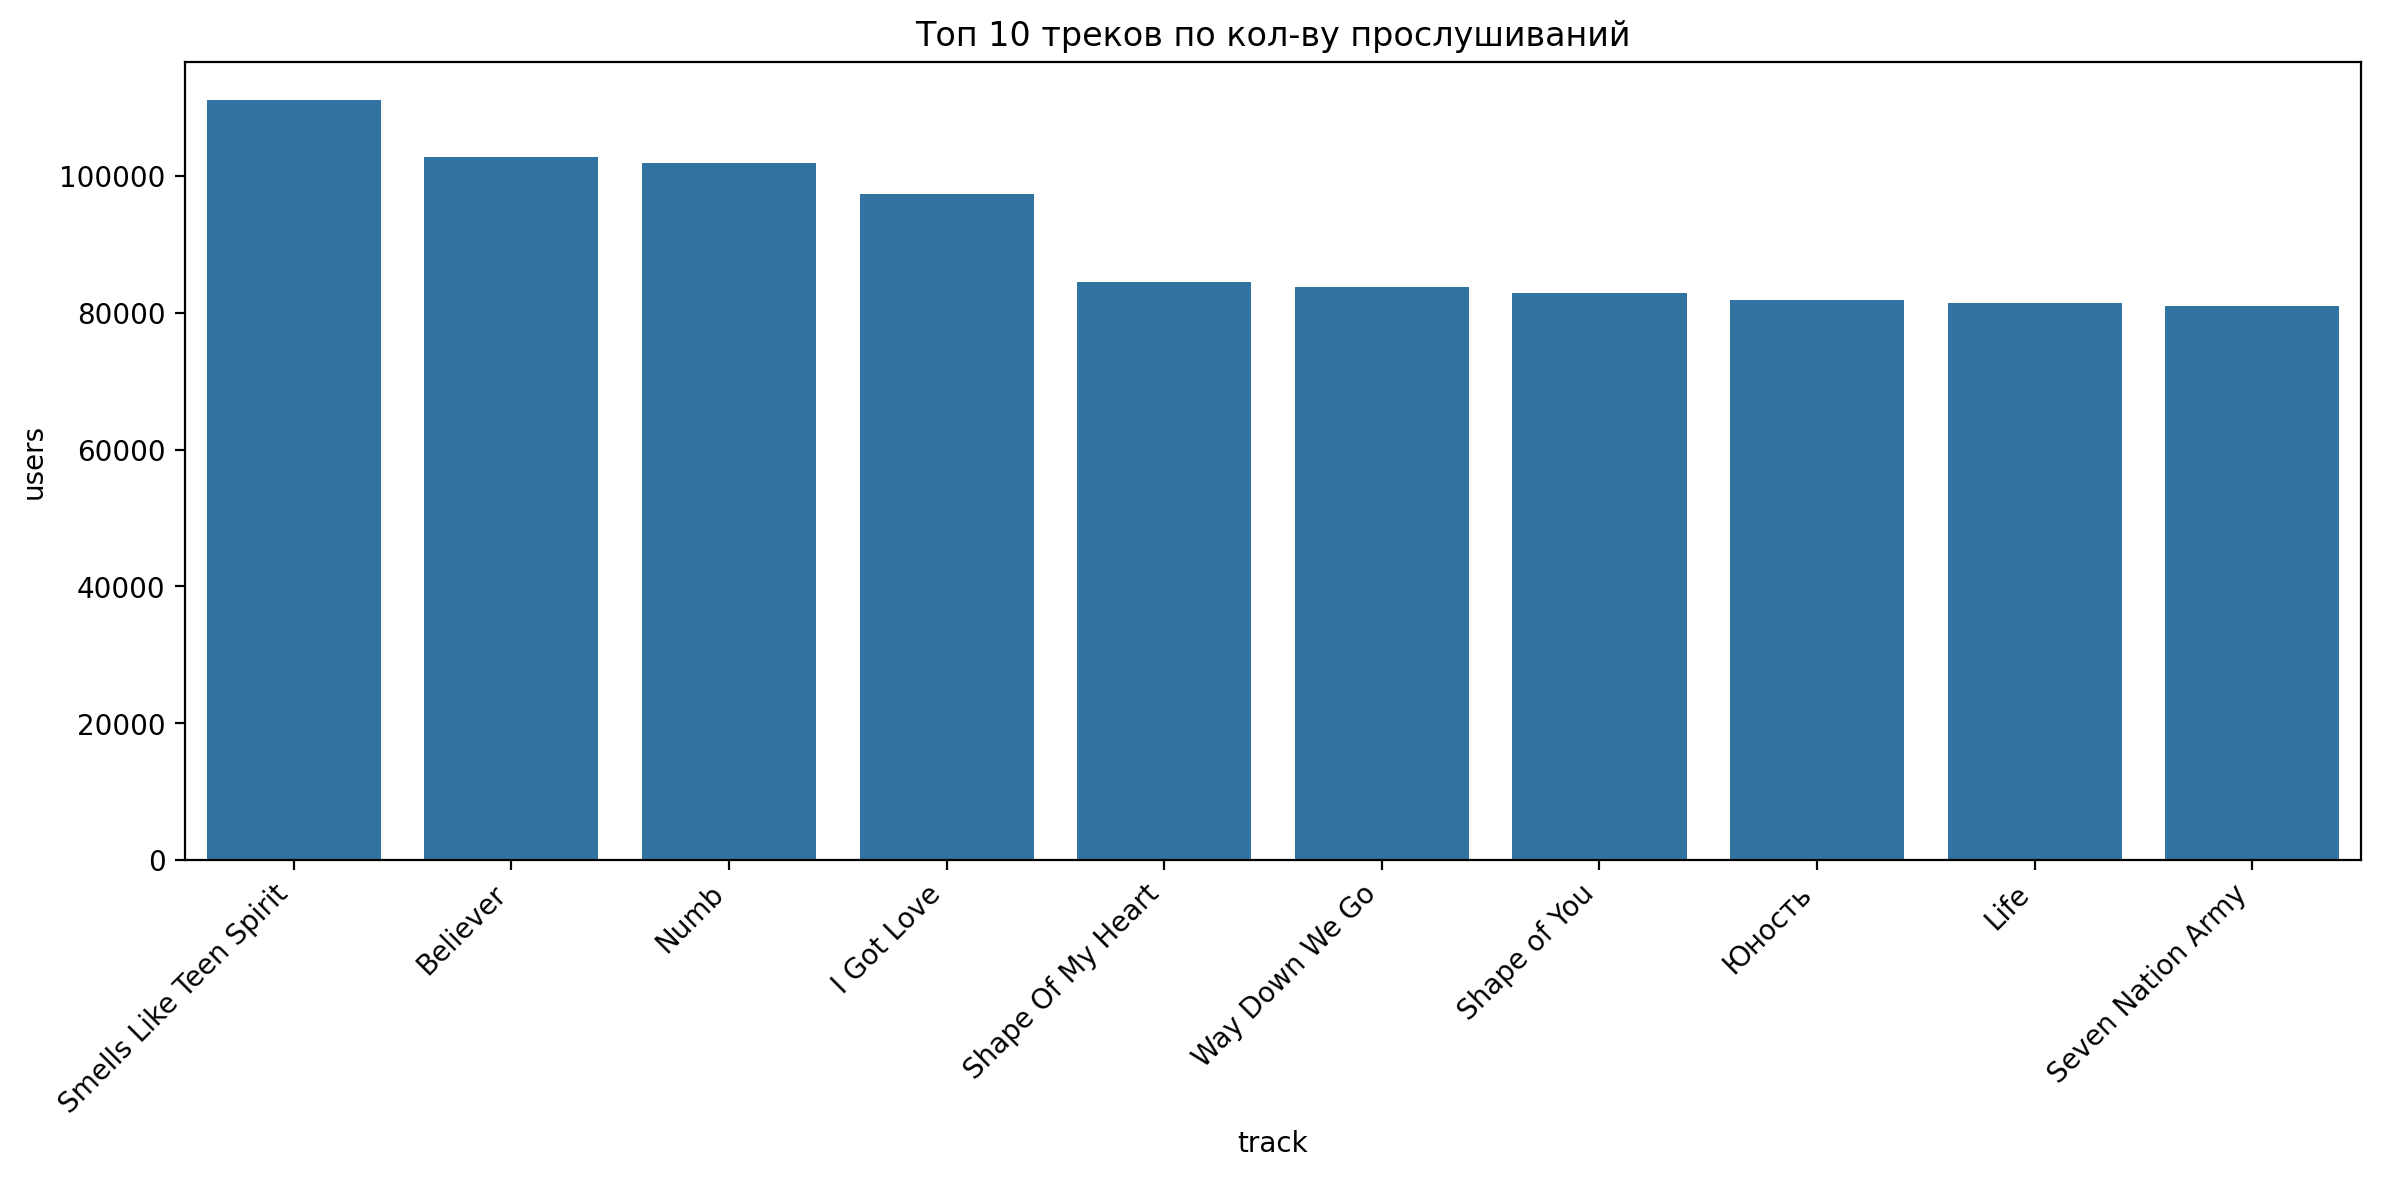

In [65]:
import seaborn as sns

plt.figure(figsize=(12, 6))
p = sns.barplot(data=interactions_by_track_top_100.sort_values('users', ascending=False).head(10), 
                x='track', y='users')
plt.title("Топ 10 треков по кол-ву прослушиваний")
plt.xticks(rotation=45, ha='right')  # ha = horizontalalignment
plt.tight_layout()
plt.show()

Треки, которые никто не прослушал

In [66]:
# Треки без взаимодействий
unlistened_tracks = interactions_by_track[interactions_by_track["users"] == 0]
print(f"Треков, которые никто не слушал: {len(unlistened_tracks)}")

Треков, которые никто не слушал: 0


# Преобразование данных

Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

In [67]:
# раскроем все списки в tracks и добавим к ним информацию из catalog_names
tracks = tracks.explode("albums").explode("artists").explode("genres").reset_index(drop=True)
tracks

,track_id,albums,artists,genres
0,26,3,16,11
1,26,3,16,21
2,26,2490753,16,11
3,26,2490753,16,21
4,38,3,16,11
...,...,...,...,...
6686875,101493057,21403883,11865715,75
6686876,101495927,21404975,4462686,3
6686877,101495927,21404975,4462686,75
6686878,101521819,21414638,5056591,3


In [68]:
tracks = tracks.rename(columns={"albums":"album_id","artists":"artist_id","genres":"genre_id"})
tracks

,track_id,album_id,artist_id,genre_id
0,26,3,16,11
1,26,3,16,21
2,26,2490753,16,11
3,26,2490753,16,21
4,38,3,16,11
...,...,...,...,...
6686875,101493057,21403883,11865715,75
6686876,101495927,21404975,4462686,3
6686877,101495927,21404975,4462686,75
6686878,101521819,21414638,5056591,3


In [69]:
tracks["track_name"] = tracks.merge(catalog_names[catalog_names["type"]=="track"],left_on="track_id",right_on="id",how="left")["name"]
tracks["album_name"] = tracks.merge(catalog_names[catalog_names["type"]=="album"],left_on="album_id",right_on="id",how="left")["name"]
tracks["artist_name"] = tracks.merge(catalog_names[catalog_names["type"]=="artist"],left_on="artist_id",right_on="id",how="left")["name"]
tracks["genre_name"] = tracks.merge(catalog_names[catalog_names["type"]=="genre"],left_on="genre_id",right_on="id",how="left")["name"]
tracks

,track_id,album_id,artist_id,genre_id,track_name,album_name,artist_name,genre_name
0,26,3,16,11,Complimentary Me,Taller Children,Elizabeth & the Catapult,pop
1,26,3,16,21,Complimentary Me,Taller Children,Elizabeth & the Catapult,folk
2,26,2490753,16,11,Complimentary Me,Taller Children,Elizabeth & the Catapult,pop
3,26,2490753,16,21,Complimentary Me,Taller Children,Elizabeth & the Catapult,folk
4,38,3,16,11,Momma's Boy,Taller Children,Elizabeth & the Catapult,pop
...,...,...,...,...,...,...,...,...
6686875,101493057,21403883,11865715,75,SKITTLES,SKITTLES,WhyBaby?,rap
6686876,101495927,21404975,4462686,3,Москва,Москва,Yanix,rusrap
6686877,101495927,21404975,4462686,75,Москва,Москва,Yanix,rap
6686878,101521819,21414638,5056591,3,Вокзал,Вокзал,Джарахов,rusrap


In [70]:
# оставим только полные данные в tracks
tracks = tracks.dropna().reset_index(drop=True)
tracks

,track_id,album_id,artist_id,genre_id,track_name,album_name,artist_name,genre_name
0,26,3,16,11,Complimentary Me,Taller Children,Elizabeth & the Catapult,pop
1,26,3,16,21,Complimentary Me,Taller Children,Elizabeth & the Catapult,folk
2,26,2490753,16,11,Complimentary Me,Taller Children,Elizabeth & the Catapult,pop
3,26,2490753,16,21,Complimentary Me,Taller Children,Elizabeth & the Catapult,folk
4,38,3,16,11,Momma's Boy,Taller Children,Elizabeth & the Catapult,pop
...,...,...,...,...,...,...,...,...
6493303,101493057,21403883,11865715,75,SKITTLES,SKITTLES,WhyBaby?,rap
6493304,101495927,21404975,4462686,3,Москва,Москва,Yanix,rusrap
6493305,101495927,21404975,4462686,75,Москва,Москва,Yanix,rap
6493306,101521819,21414638,5056591,3,Вокзал,Вокзал,Джарахов,rusrap


In [71]:
# соберем обратно в списки данные по трекам
tracks = tracks.groupby("track_id").agg({'album_id':lambda x: list(set(list(x))),
                               'artist_id':lambda x: list(set(list(x))),
                               'genre_id':lambda x: list(set(list(x))),
                               'track_name':lambda x: list(set(list(x))),
                               'album_name':lambda x: list(set(list(x))),
                               'artist_name':lambda x: list(set(list(x))),
                               'genre_name':lambda x: list(set(list(x)))}).reset_index()
tracks

,track_id,album_id,artist_id,genre_id,track_name,album_name,artist_name,genre_name
0,26,"[2490753, 3]",[16],"[11, 21]",[Complimentary Me],[Taller Children],[Elizabeth & the Catapult],"[pop, folk]"
1,38,"[2490753, 3]",[16],"[11, 21]",[Momma's Boy],[Taller Children],[Elizabeth & the Catapult],"[pop, folk]"
2,135,"[2490809, 12, 214]",[84],[11],[Atticus],[Wild Young Hearts],[Noisettes],[pop]
3,136,"[2490809, 12, 214]",[84],[11],[24 Hours],[Wild Young Hearts],[Noisettes],[pop]
4,138,"[213505, 322, 72292, 6007655, 12, 17294156, 72...",[84],[11],[Don't Upset The Rhythm (Go Baby Go)],"[I Am On Holiday, 2000s Indie Nostalgia, Wild ...",[Noisettes],[pop]
...,...,...,...,...,...,...,...,...
980965,101478482,[21399811],[5540395],"[75, 3]",[На лицо],[На лицо],[FLESH],"[rap, rusrap]"
980966,101490148,[21403052],[9078726],"[11, 20]",[Без капли мысли],[Без капли мысли],[Даня Милохин],"[pop, ruspop]"
980967,101493057,[21403883],[11865715],"[75, 44]",[SKITTLES],[SKITTLES],[WhyBaby?],"[foreignrap, rap]"
980968,101495927,[21404975],[4462686],"[75, 3]",[Москва],[Москва],[Yanix],"[rap, rusrap]"


In [72]:
# оставим только те события, по которым есть информация в tracks
existing_tracks_list = tracks["track_id"].drop_duplicates().to_list()
interactions = interactions_clean[interactions_clean["track_id"].isin(existing_tracks_list)].reset_index(drop=True)
interactions

,user_id,track_id,track_seq,started_at,started_at_month
0,0,99262,1,2022-07-17,7
1,0,589498,2,2022-07-19,7
2,0,590262,3,2022-07-21,7
3,0,590303,4,2022-07-22,7
4,0,590692,5,2022-07-22,7
...,...,...,...,...,...
195486727,1374582,95514767,288,2022-12-29,12
195486728,1374582,97220301,289,2022-12-29,12
195486729,1374582,97241171,290,2022-12-29,12
195486730,1374582,98542641,291,2022-12-29,12


In [73]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980970 entries, 0 to 980969
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   track_id     980970 non-null  int32 
 1   album_id     980970 non-null  object
 2   artist_id    980970 non-null  object
 3   genre_id     980970 non-null  object
 4   track_name   980970 non-null  object
 5   album_name   980970 non-null  object
 6   artist_name  980970 non-null  object
 7   genre_name   980970 non-null  object
dtypes: int32(1), object(7)
memory usage: 56.1+ MB


In [74]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195486732 entries, 0 to 195486731
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   user_id           int32         
 1   track_id          int32         
 2   track_seq         int16         
 3   started_at        datetime64[ns]
 4   started_at_month  int8          
dtypes: datetime64[ns](1), int16(1), int32(2), int8(1)
memory usage: 3.5 GB


# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [75]:
items = tracks.copy()
events = interactions.copy()

In [76]:
items.to_parquet("items.parquet")
events.to_parquet("events.parquet")

# Проверяем размер файлов
import os

items_size = os.path.getsize("items.parquet")
events_size = os.path.getsize("events.parquet")

print("Размер файлов:")
print(f"items.parquet: {items_size / (1024**2):.2f} MB")
print(f"events.parquet: {events_size / (1024**2):.2f} MB")
print(f"Общий размер: {(items_size + events_size) / (1024**2):.2f} MB")

Размер файлов:
items.parquet: 66.61 MB
events.parquet: 803.83 MB
Общий размер: 870.43 MB


In [77]:
import boto3
from dotenv import load_dotenv
import os
import io
load_dotenv()

AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')
S3_SERVICE_NAME = 's3'
S3_ENDPOINT_URL = os.environ.get('S3_ENDPOINT_URL')
BUCKET_NAME = os.environ.get('S3_BUCKET_NAME')

session = boto3.session.Session()

s3 = session.client(
        service_name=S3_SERVICE_NAME,
        endpoint_url=S3_ENDPOINT_URL,
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY
    )

s3.upload_file('items.parquet', BUCKET_NAME, 'recsys/data/items.parquet')
s3.upload_file('events.parquet', BUCKET_NAME, 'recsys/data/events.parquet')

In [78]:
# проверка загрузки:

def check_our_files():
    #s3 = s3
    #bucket_name = os.environ.get('S3_BUCKET_NAME')
    
    target_files = ['recsys/data/items.parquet', 'recsys/data/events.parquet']
    
    print("  Проверка загрузки файлов:")
    print("=" * 50)
    
    for file_key in target_files:
        try:
            response = s3.head_object(Bucket=BUCKET_NAME, Key=file_key)
            print(f"{file_key} - ЗАГРУЖЕН")
            print(f"   Размер: { round(response['ContentLength']/(1024 ** 2), 2)} MB")
            print(f"   Последнее изменение: {response['LastModified']}")
        except Exception as e:
            print(f"{file_key} - ОТСУТСТВУЕТ: {e}")
        print("-" * 50)

check_our_files()

  Проверка загрузки файлов:
recsys/data/items.parquet - ЗАГРУЖЕН
   Размер: 66.61 MB
   Последнее изменение: 2025-08-24 11:32:13+00:00
--------------------------------------------------
recsys/data/events.parquet - ЗАГРУЖЕН
   Размер: 803.83 MB
   Последнее изменение: 2025-08-24 11:32:22+00:00
--------------------------------------------------


# !!!!!

В датасете 195+ миллионов событий (взаимодействий), и машина не справляется. Проведем дополнительный анализ и фильтрацию

In [1]:
# Для очистки памяти следует перезапустить kernel.
# Все импорты и файлы items.par и events.par будут загружены заново ниже.

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os

In [2]:
items = pd.read_parquet("items.parquet")
events = pd.read_parquet("events.parquet")

In [3]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980970 entries, 0 to 980969
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   track_id     980970 non-null  int32 
 1   album_id     980970 non-null  object
 2   artist_id    980970 non-null  object
 3   genre_id     980970 non-null  object
 4   track_name   980970 non-null  object
 5   album_name   980970 non-null  object
 6   artist_name  980970 non-null  object
 7   genre_name   980970 non-null  object
dtypes: int32(1), object(7)
memory usage: 56.1+ MB


In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195486732 entries, 0 to 195486731
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   user_id           int32         
 1   track_id          int32         
 2   track_seq         int16         
 3   started_at        datetime64[ns]
 4   started_at_month  int8          
dtypes: datetime64[ns](1), int16(1), int32(2), int8(1)
memory usage: 3.5 GB


Статистика по пользователям:
count    1.372767e+06
mean     1.424034e+02
std      2.134864e+02
min      1.000000e+00
25%      2.300000e+01
50%      5.500000e+01
75%      1.530000e+02
max      1.000000e+03
Name: count, dtype: float64

Медиана: 55.0
90-й перцентиль: 388.0

Статистика по трекам:
count    980188.000000
mean        199.437998
std        1306.899838
min           1.000000
25%           7.000000
50%          15.000000
75%          54.000000
max      111062.000000
Name: count, dtype: float64

Медиана: 15.0
90-й перцентиль: 250.0


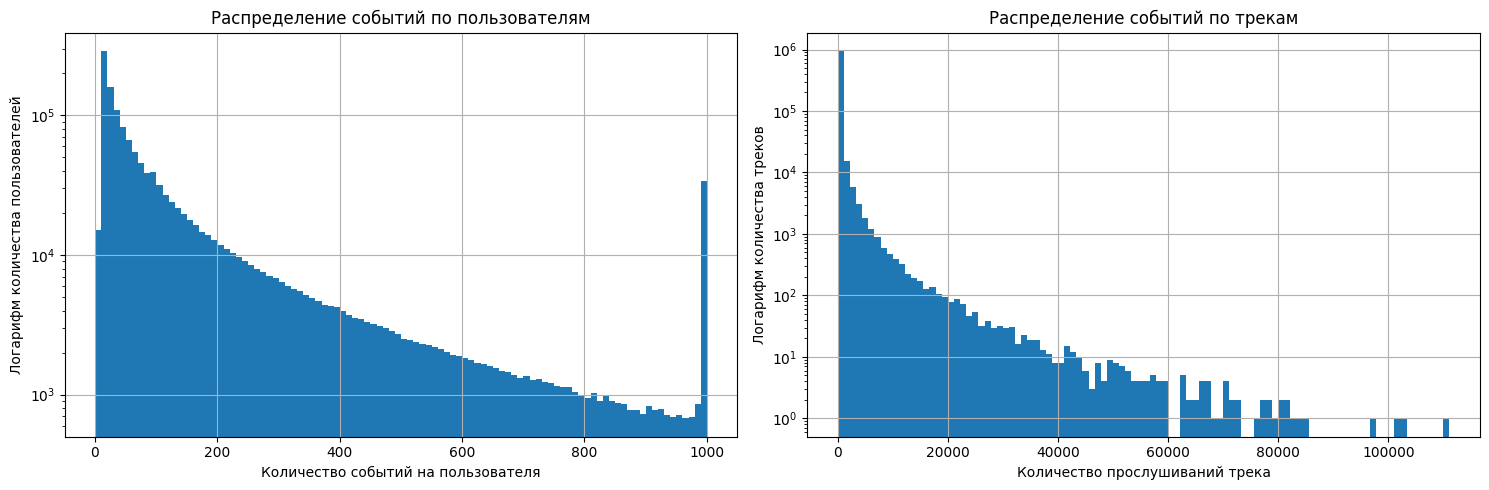


Топ-10 самых активных пользователей:
user_id
1209932    1000
696726     1000
696671     1000
169505     1000
169530     1000
169406     1000
68         1000
1036256    1000
1265249    1000
1265259    1000
Name: count, dtype: int64

Топ-10 самых популярных треков:
track_id
53404       111062
33311009    102762
178529      101913
35505245     97421
795836       84546
24692821     83811
32947997     82880
65851540     81899
45499814     81401
6705392      81063
Name: count, dtype: int64


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Посчитаем базовую статистику по пользователям и трекам
user_stats = events['user_id'].value_counts()
track_stats = events['track_id'].value_counts()

print("Статистика по пользователям:")
print(user_stats.describe())
print(f"\nМедиана: {user_stats.median()}")
print(f"90-й перцентиль: {user_stats.quantile(0.9)}")

print("\nСтатистика по трекам:")
print(track_stats.describe())
print(f"\nМедиана: {track_stats.median()}")
print(f"90-й перцентиль: {track_stats.quantile(0.9)}")

# Построим гистограммы распределения (логарифмическая шкала)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Гистограмма для пользователей
user_stats.hist(bins=100, ax=ax1)
ax1.set_yscale('log')  # Правильный способ установить логарифмическую шкалу
ax1.set_title('Распределение событий по пользователям')
ax1.set_xlabel('Количество событий на пользователя')
ax1.set_ylabel('Логарифм количества пользователей')

# Гистограмма для треков
track_stats.hist(bins=100, ax=ax2)
ax2.set_yscale('log')  # Правильный способ установить логарифмическую шкалу
ax2.set_title('Распределение событий по трекам')
ax2.set_xlabel('Количество прослушиваний трека')
ax2.set_ylabel('Логарифм количества треков')

plt.tight_layout()
plt.show()

# Посмотрим на топ самых активных пользователей
print("\nТоп-10 самых активных пользователей:")
print(user_stats.head(10))

print("\nТоп-10 самых популярных треков:")
print(track_stats.head(10))

Пользователи:  
- Медиана: 55 взаимодействий на пользователя  
- 90-й перцентиль: 388 - это хороший активный пользователь  
- Максимум: 1000 - это сверхактивные пользователи (скорее всего, боты или тестовые аккаунты)  

Треки:  
- Медиана: 15 прослушиваний на трек 
- 90-й перцентиль: 250 - популярные треки  
- Максимум: 111,062 - супер-хиты

In [6]:
min_user_interactions = 20    # Берем только достаточно активных пользователей (>= 20 взаимодействий)
min_track_interactions = 10   # Берем только достаточно популярные треки (>= 10 прослушиваний)
max_interactions_per_user = 100  # ОБРЕЗАЕМ до 100 последних взаимодействий на пользователя

print("Процент пользователей после фильтрации:")
total_users = events['user_id'].nunique()
filtered_users = (user_stats >= min_user_interactions).sum()
print(f"Пользователей >= {min_user_interactions} взаимодействий: {filtered_users}/{total_users} ({filtered_users/total_users*100:.1f}%)")

Процент пользователей после фильтрации:
Пользователей >= 20 взаимодействий: 1090500/1372767 (79.4%)


In [7]:
print("\nПроцент треков после фильтрации:")
total_tracks = events['track_id'].nunique()
filtered_tracks = (track_stats >= min_track_interactions).sum()
print(f"Треков >= {min_track_interactions} прослушиваний: {filtered_tracks}/{total_tracks} ({filtered_tracks/total_tracks*100:.1f}%)")


Процент треков после фильтрации:
Треков >= 10 прослушиваний: 616217/980188 (62.9%)


In [8]:
# ФИЛЬТРАЦИЯ
# Фильтрация пользователей
valid_users = user_stats[user_stats >= min_user_interactions].index
filtered_events = events[events['user_id'].isin(valid_users)]

# Фильтрация треков
valid_tracks = track_stats[track_stats >= min_track_interactions].index
filtered_events = filtered_events[filtered_events['track_id'].isin(valid_tracks)]

# Обрезка истории активных пользователей (САМОЕ ВАЖНОЕ!)
filtered_events = filtered_events.sort_values(['user_id', 'started_at'])
trimmed_events = filtered_events.groupby('user_id').tail(max_interactions_per_user)

print(f"\nРезультаты фильтрации:")
print(f"Исходный размер: {len(events):,} событий")
print(f"После фильтрации пользователей: {len(filtered_events):,} событий")
print(f"После обрезки истории: {len(trimmed_events):,} событий")
print(f"Уникальных пользователей: {trimmed_events['user_id'].nunique():,}")
print(f"Уникальных треков: {trimmed_events['track_id'].nunique():,}")


Результаты фильтрации:
Исходный размер: 195,486,732 событий
После фильтрации пользователей: 189,476,876 событий
После обрезки истории: 76,675,578 событий
Уникальных пользователей: 1,090,496
Уникальных треков: 609,516


In [9]:
# ДОПОЛНИТЕЛЬНАЯ АГРЕССИВНАЯ ФИЛЬТРАЦИЯ
print("Дополнительная оптимизация датасета:")

# 1. Фильтрация по процентилям - берем только самых активных пользователей и популярных треков
user_95_percentile = user_stats.quantile(0.95)  # 95-й перцентиль пользователей
track_95_percentile = track_stats.quantile(0.95)  # 95-й перцентиль треков

print(f"95-й перцентиль пользователей: {user_95_percentile:.0f} взаимодействий")
print(f"95-й перцентиль треков: {track_95_percentile:.0f} прослушиваний")

# 2. Берем только топ 20% самых активных пользователей и популярных треков
min_user_interactions_aggro = 100  # Более агрессивный порог
min_track_interactions_aggro = 50   # Более агрессивный порог
max_interactions_per_user_aggro = 50  # Всего 50 последних взаимодействий

print(f"\nАгрессивные параметры:")
print(f"Пользователи: >= {min_user_interactions_aggro} взаимодействий")
print(f"Треки: >= {min_track_interactions_aggro} прослушиваний")
print(f"Максимум на пользователя: {max_interactions_per_user_aggro} взаимодействий")

# 3. Применяем агрессивную фильтрацию
valid_users_aggro = user_stats[user_stats >= min_user_interactions_aggro].index
valid_tracks_aggro = track_stats[track_stats >= min_track_interactions_aggro].index

aggro_events = events[events['user_id'].isin(valid_users_aggro)]
aggro_events = aggro_events[aggro_events['track_id'].isin(valid_tracks_aggro)]

# 4. Обрезаем до 50 последних взаимодействий на пользователя
aggro_events = aggro_events.sort_values(['user_id', 'started_at'])
aggro_events = aggro_events.groupby('user_id').tail(max_interactions_per_user_aggro)

print(f"\nРезультаты агрессивной фильтрации:")
print(f"Размер датасета: {len(aggro_events):,} событий")
print(f"Уникальных пользователей: {aggro_events['user_id'].nunique():,}")
print(f"Уникальных треков: {aggro_events['track_id'].nunique():,}")

# 5. Оценка размера матрицы
approx_matrix_size = aggro_events['user_id'].nunique() * aggro_events['track_id'].nunique()
approx_matrix_density = len(aggro_events) / approx_matrix_size * 100

print(f"\nОценка матрицы пользователь-трек:")
print(f"Размерность: {aggro_events['user_id'].nunique():,} x {aggro_events['track_id'].nunique():,}")
print(f"Заполненность: {approx_matrix_density:.4f}%")

Дополнительная оптимизация датасета:
95-й перцентиль пользователей: 649 взаимодействий
95-й перцентиль треков: 652 прослушиваний

Агрессивные параметры:
Пользователи: >= 100 взаимодействий
Треки: >= 50 прослушиваний
Максимум на пользователя: 50 взаимодействий

Результаты агрессивной фильтрации:
Размер датасета: 23,839,092 событий
Уникальных пользователей: 477,029
Уникальных треков: 238,752

Оценка матрицы пользователь-трек:
Размерность: 477,029 x 238,752
Заполненность: 0.0209%


Анализ результатов:  

Получившиеся характеристики датасета:  
- Размер датасета: 23.8M событий (из исходных 195M) - управляемый размер  
- Пользователи: 477K активных пользователей (≥100 взаимодействий)  
- Треки: 239K популярных треков (≥50 прослушиваний)  
- Только активные пользователи и популярные треки - качественные данные  
- Заполненность матрицы: 0.021% - идеально для sparse матриц! - хорошая разреженность  

Достаточный объем: 477K пользователей и 239K треков - богатый датасет для обучения

In [10]:
aggro_events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23839092 entries, 305 to 195486731
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   user_id           int32         
 1   track_id          int32         
 2   track_seq         int16         
 3   started_at        datetime64[ns]
 4   started_at_month  int8          
dtypes: datetime64[ns](1), int16(1), int32(2), int8(1)
memory usage: 613.8 MB


In [11]:
# Создаем директорию для данных, если ее нет
output_dir = "recsys_data"
os.makedirs(output_dir, exist_ok=True)

# Сохраняем отфильтрованные items
items_output_path = f"{output_dir}/filtered_items.parquet"
items.to_parquet(items_output_path, engine='pyarrow', compression='snappy')
print(f"Items сохранены: {items_output_path}")
print(f"Размер: {len(items):,} записей")

# Сохраняем агрессивно отфильтрованную версию для быстрых экспериментов
aggro_events_output_path = f"{output_dir}/filtered_events.parquet"
aggro_events.to_parquet(aggro_events_output_path, engine='pyarrow', compression='snappy')
print(f"\nAggressive events сохранены: {aggro_events_output_path}")
print(f"Размер: {len(aggro_events):,} событий")

# Проверяем размер файлов
import os
print(f"\nРазмер файлов:")
print(f"Items: {os.path.getsize(items_output_path) / 1024 / 1024:.1f} MB")
print(f"Events aggressive: {os.path.getsize(aggro_events_output_path) / 1024 / 1024:.1f} MB")

Items сохранены: recsys_data/filtered_items.parquet
Размер: 980,970 записей

Aggressive events сохранены: recsys_data/filtered_events.parquet
Размер: 23,839,092 событий

Размер файлов:
Items: 66.6 MB
Events aggressive: 194.0 MB


In [12]:
import boto3
from dotenv import load_dotenv
import os
import io
load_dotenv()

AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')
S3_SERVICE_NAME = 's3'
S3_ENDPOINT_URL = os.environ.get('S3_ENDPOINT_URL')
BUCKET_NAME = os.environ.get('S3_BUCKET_NAME')

session = boto3.session.Session()

s3 = session.client(
        service_name=S3_SERVICE_NAME,
        endpoint_url=S3_ENDPOINT_URL,
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY
    )

s3.upload_file(
    os.path.join(output_dir, 'filtered_items.parquet'), 
    BUCKET_NAME, 
    'recsys/data/filtered_items.parquet'
)

s3.upload_file(
    os.path.join(output_dir, 'filtered_events.parquet'), 
    BUCKET_NAME, 
    'recsys/data/filtered_events.parquet'
)

In [13]:
# проверка загрузки:

def check_our_files():
    #s3 = s3
    #bucket_name = os.environ.get('S3_BUCKET_NAME')
    
    target_files = ['recsys/data/filtered_items.parquet', 'recsys/data/filtered_events.parquet']
    
    print("  Проверка загрузки файлов:")
    print("=" * 50)
    
    for file_key in target_files:
        try:
            response = s3.head_object(Bucket=BUCKET_NAME, Key=file_key)
            print(f"{file_key} - ЗАГРУЖЕН")
            print(f"   Размер: { round(response['ContentLength']/(1024 ** 2), 2)} MB")
            print(f"   Последнее изменение: {response['LastModified']}")
        except Exception as e:
            print(f"{file_key} - ОТСУТСТВУЕТ: {e}")
        print("-" * 50)

check_our_files()

  Проверка загрузки файлов:
recsys/data/filtered_items.parquet - ЗАГРУЖЕН
   Размер: 66.61 MB
   Последнее изменение: 2025-08-25 05:11:02+00:00
--------------------------------------------------
recsys/data/filtered_events.parquet - ЗАГРУЖЕН
   Размер: 194.01 MB
   Последнее изменение: 2025-08-25 05:11:04+00:00
--------------------------------------------------


# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

Для очистки памяти следует перезапустить kernel. Все импорты и файлы items.parquet и events.parquet будут загружены заново ниже.parquet

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
items = pd.read_parquet("recsys_data/filtered_items.parquet")
events = pd.read_parquet("recsys_data/filtered_events.parquet")

In [3]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23839092 entries, 305 to 195486731
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   user_id           int32         
 1   track_id          int32         
 2   track_seq         int16         
 3   started_at        datetime64[ns]
 4   started_at_month  int8          
dtypes: datetime64[ns](1), int16(1), int32(2), int8(1)
memory usage: 613.8 MB


# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [4]:
# зададим точку разбиения
train_test_global_time_split_date = pd.to_datetime("2022-12-16")

train_test_global_time_split_idx = events["started_at"] < train_test_global_time_split_date

interactions_train = events[train_test_global_time_split_idx].reset_index(drop=True)
interactions_test  = events[~train_test_global_time_split_idx].reset_index(drop=True)

In [5]:
print(interactions_train.shape)
print(interactions_test.shape)

(18032716, 5)
(5806376, 5)


In [6]:
display(interactions_train['started_at'].describe())
display(interactions_test['started_at'].describe())

count                         18032716
mean     2022-10-24 06:32:01.576230144
min                2022-01-01 00:00:00
25%                2022-10-03 00:00:00
50%                2022-11-10 00:00:00
75%                2022-12-01 00:00:00
max                2022-12-15 00:00:00
Name: started_at, dtype: object

count                          5806376
mean     2022-12-22 19:31:37.636391680
min                2022-12-16 00:00:00
25%                2022-12-19 00:00:00
50%                2022-12-23 00:00:00
75%                2022-12-26 00:00:00
max                2022-12-31 00:00:00
Name: started_at, dtype: object

In [7]:
# количество пользователей в train и test
print(len(interactions_train["user_id"].drop_duplicates()))
print(len(interactions_test["user_id"].drop_duplicates()))

428060
256994


In [8]:
# анализ холодного старта
items_in_train = set(interactions_train.track_id.unique())
items_in_test = set(interactions_test.track_id.unique())
items_diff = items_in_test.difference(items_in_train)

print(f"Треков в train: {len(items_in_train):,}")
print(f"Треков в test: {len(items_in_test):,}")
print(f"Новых треков в test (cold start): {len(items_diff):,} ({len(items_diff)/len(items_in_test)*100:.1f}%)")

Треков в train: 238,279
Треков в test: 166,890
Новых треков в test (cold start): 473 (0.3%)


In [9]:
# Дропаем items в test которых нет в train
original_test_size = len(interactions_test)
interactions_test = interactions_test[interactions_test['track_id'].isin(items_in_train)]
print(f"Test set после фильтрации: {len(interactions_test):,} (удалено {original_test_size - len(interactions_test):,} событий)")

Test set после фильтрации: 5,805,837 (удалено 539 событий)


In [10]:
# проверяем
items_in_test = set(interactions_test.track_id.unique())
items_diff = items_in_test.difference(items_in_train)
len(items_diff)

0

In [11]:
print(f"Train size: {len(interactions_train):,} ({len(interactions_train)/len(events)*100:.1f}%)")
print(f"Test size: {len(interactions_test):,} ({len(interactions_test)/len(events)*100:.1f}%)")

Train size: 18,032,716 (75.6%)
Test size: 5,805,837 (24.4%)


In [12]:
# промежуточное сохранение
# Создаем директорию для данных, если ее нет
output_dir = "recsys_data_split"
os.makedirs(output_dir, exist_ok=True)

# Сохраняем interactions_train
train_output_path = f"{output_dir}/interactions_train.parquet"
interactions_train.to_parquet(train_output_path, engine='pyarrow', compression='snappy')
print(f"train сохранен: {train_output_path}")
print(f"Размер: {len(interactions_train):,} записей")
print("-" * 50)

# Сохраняем interactions_test
test_output_path = f"{output_dir}/interactions_test.parquet"
interactions_test.to_parquet(test_output_path, engine='pyarrow', compression='snappy')
print(f"test сохранен: {test_output_path}")
print(f"Размер: {len(interactions_test):,} записей")

train сохранен: recsys_data_split/interactions_train.parquet
Размер: 18,032,716 записей
--------------------------------------------------
test сохранен: recsys_data_split/interactions_test.parquet
Размер: 5,805,837 записей


# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
interactions_train = pd.read_parquet("recsys_data_split/interactions_train.parquet")
interactions_test = pd.read_parquet("recsys_data_split/interactions_test.parquet")

In [3]:
interactions_train.head()

,user_id,track_id,track_seq,started_at,started_at_month
0,4,59535907,198,2022-11-03,11
1,4,60102026,199,2022-11-03,11
2,4,61424101,200,2022-11-03,11
3,4,61743648,202,2022-11-06,11
4,4,62070146,203,2022-11-07,11


In [4]:
# группируем данные по track_id и посчитаем кол-во уникальных пользователей users, которые слушали трек. 
# Добавим колонку с медианой номера места трека в истории пользователя
# А также добавим долю прослушиваний в виде avg_rating

item_popularity = interactions_train.groupby("track_id").agg(users=("user_id", "nunique"), track_seq_median=("track_seq", "median")).sort_values(by=["users","track_seq_median"], ascending=[False,True]).reset_index()
item_popularity["avg_rating"] = round(1000*(item_popularity["users"]/item_popularity["users"].sum()),2)
item_popularity

,track_id,users,track_seq_median,avg_rating
0,83063895,21103,189.0,1.17
1,81848875,20440,185.0,1.13
2,84382282,20167,215.0,1.12
3,78426489,18910,181.0,1.05
4,93126179,17743,226.0,0.98
...,...,...,...,...
238274,38876141,1,1000.0,0.00
238275,40173196,1,1000.0,0.00
238276,41786931,1,1000.0,0.00
238277,50276864,1,1000.0,0.00


In [5]:
item_popularity["popularity_weighted"] = (
    item_popularity["users"] *                              # Чем больше пользователей - тем популярнее
    (1 / (item_popularity["track_seq_median"] + 1e-10)) *   # Чем МЕНЬШЕ медиана (раньше в истории) - тем популярнее  
    item_popularity["avg_rating"]                           # Дополнительный вес от доли прослушиваний
) / 1000                                                    # Меньший делитель для нормализации

item_popularity["popularity_weighted"] = item_popularity["popularity_weighted"].round(2)

item_popularity

,track_id,users,track_seq_median,avg_rating,popularity_weighted
0,83063895,21103,189.0,1.17,0.13
1,81848875,20440,185.0,1.13,0.12
2,84382282,20167,215.0,1.12,0.11
3,78426489,18910,181.0,1.05,0.11
4,93126179,17743,226.0,0.98,0.08
...,...,...,...,...,...
238274,38876141,1,1000.0,0.00,0.00
238275,40173196,1,1000.0,0.00,0.00
238276,41786931,1,1000.0,0.00,0.00
238277,50276864,1,1000.0,0.00,0.00


In [6]:
# Берем топ-100 самых популярных
# сортируем по popularity_weighted
column_to_rank = "popularity_weighted"
item_popularity = item_popularity.sort_values(by=column_to_rank,ascending=False).reset_index(drop=True)

# выбираем первые 100 треков
top_k_pop_items = item_popularity.head(100)

top_k_pop_items

,track_id,users,track_seq_median,avg_rating,popularity_weighted
0,83063895,21103,189.0,1.17,0.13
1,81848875,20440,185.0,1.13,0.12
2,84382282,20167,215.0,1.12,0.11
3,78426489,18910,181.0,1.05,0.11
4,65851540,16278,152.0,0.90,0.10
...,...,...,...,...,...
95,51165489,4560,136.0,0.25,0.01
96,33977439,4593,119.0,0.25,0.01
97,72112988,4606,190.0,0.26,0.01
98,56312027,4619,124.0,0.26,0.01


In [7]:
items = pd.read_parquet("recsys_data/filtered_items.parquet")

In [8]:
# добавляем информацию о треках и выводим информацию о топовых треках
top_k_pop_items = top_k_pop_items.merge(items[["track_id",'track_name','album_name','artist_name','genre_name']], on="track_id")
top_k_pop_items[["track_id", "users", "avg_rating", "popularity_weighted", 'track_name','album_name','artist_name','genre_name']].head(25)

,track_id,users,avg_rating,popularity_weighted,track_name,album_name,artist_name,genre_name
0,83063895,21103,1.17,0.13,[Птичка],[Птичка],[HammAli & Navai],"[pop, ruspop]"
1,81848875,20440,1.13,0.12,[Федерико Феллини],[Федерико Феллини],[Galibri & Mavik],"[pop, ruspop]"
2,84382282,20167,1.12,0.11,[Я в моменте],[Я в моменте],"[Markul, Джарахов]","[rap, rusrap]"
3,78426489,18910,1.05,0.11,[Rampampam],[Rampampam],[Minelli],[dance]
4,65851540,16278,0.90,0.10,[Юность],[Юность],[Dabro],"[pop, ruspop]"
5,60292250,16527,0.92,0.09,[Blinding Lights],"[Blinding Lights, After Hours, The Highlights]",[The Weeknd],[rnb]
6,76434671,16450,0.91,0.09,[Горький вкус],"[Горячие Хиты Кавказа 2, Горький вкус]",[Султан Лагучев],"[caucasian, folk]"
7,93126179,17743,0.98,0.08,[Солнце Монако],[The End],[Люся Чеботина],"[pop, ruspop]"
8,75944934,16086,0.89,0.07,[Astronaut In The Ocean],"[Astronaut In The Ocean, Astronomical]",[Masked Wolf],"[foreignrap, rap]"
9,84382287,14892,0.83,0.06,[Пошла жара],"[ПОШЛА ЖАРА, Пошла жара]","[GAYAZOV$ BROTHER$, Filatov & Karas]","[pop, ruspop]"


что-то даже похоже)))

In [9]:
# Для какой доли событий «холодных» пользователей в events_test рекомендации в top_k_pop_items совпали по трекам

# выделим общих пользователей 
users_train = interactions_train["user_id"].drop_duplicates().to_frame().reset_index(drop=True)
users_test = interactions_test["user_id"].drop_duplicates().to_frame().reset_index(drop=True)
common_users = users_train.merge(users_test, on="user_id", how="outer", indicator="indic")

# холодные пользователи - пользователи, которых нет в обучающей выборке
cold_users = common_users[common_users["indic"] == "right_only"]["user_id"].to_list()
print("len(users_test): ", len(users_test))
print("len(cold_users): ", len(cold_users))
print("ratio: ", round(100*(len(cold_users)/len(users_test)),2), "%")

# Расчет доли совпадений
cold_users_interactions = interactions_test[interactions_test["user_id"].isin(cold_users)]

# Проверяем совпадения
cold_tracks_in_top = cold_users_interactions["track_id"].isin(top_k_pop_items["track_id"])
match_ratio = cold_tracks_in_top.mean()
matched_count = cold_tracks_in_top.sum()
total_count = len(cold_tracks_in_top)

print(f"События холодных пользователей: {total_count}")
print(f"Совпало с рекомендациями: {matched_count}")
print(f"Доля совпадений: {match_ratio:.4f} ({match_ratio*100:.2f}%)")

len(users_test):  256993
len(cold_users):  48969
ratio:  19.05 %
События холодных пользователей: 2448032
Совпало с рекомендациями: 137208
Доля совпадений: 0.0560 (5.60%)


In [10]:
# Покрытие/охват cold_users (Coverage of Cold Users/Cold User Recall)

cold_users_interactions = interactions_test[interactions_test["user_id"].isin(cold_users)]

# Сразу считаем уникальных пользователей с совпадениями
users_with_matches = cold_users_interactions[
    cold_users_interactions["track_id"].isin(top_k_pop_items["track_id"])
]["user_id"].nunique()

total_cold_users = len(cold_users)

print("len(cold_users):", total_cold_users)
print("Уникальных пользователей с совпадениями:", users_with_matches)
print("ratio: ", round(100*(users_with_matches/total_cold_users), 2), "%")

len(cold_users): 48969
Уникальных пользователей с совпадениями: 36745
ratio:  75.04 %


Система эффективна для 75% новых пользователей. Базовый подход с топ популярными работает хорошо.

In [11]:
cold_users_events_with_recs = interactions_test[interactions_test["user_id"].isin(cold_users)].merge(
    top_k_pop_items[["track_id", "popularity_weighted"]], 
    on="track_id", 
    how="left"
)

# Считаем покрытие для каждого пользователя
cold_users_hit_ratio = cold_users_events_with_recs.groupby("user_id").agg(
    hits=("popularity_weighted", lambda x: (~x.isnull()).mean())
).reset_index()

# Анализируем результаты
users_with_zero_hits = (cold_users_hit_ratio["hits"] == 0).mean()
users_with_hits = cold_users_hit_ratio[cold_users_hit_ratio["hits"] > 0]
average_coverage = users_with_hits["hits"].mean() if len(users_with_hits) > 0 else 0

print(f"Доля пользователей без релевантных рекомендаций: {users_with_zero_hits:.2%}")
print(f"Доля пользователей с релевантными рекомендациями: {1 - users_with_zero_hits:.2%}")
print(f"Среднее покрытие пользователей (кто имеет совпадения): {average_coverage:.2%}")
print(f"Общее среднее покрытие: {cold_users_hit_ratio['hits'].mean():.2%}")

Доля пользователей без релевантных рекомендаций: 24.96%
Доля пользователей с релевантными рекомендациями: 75.04%
Среднее покрытие пользователей (кто имеет совпадения): 7.47%
Общее среднее покрытие: 5.60%


In [12]:
# Воссоздаем необходимые переменные
cold_users_interactions = interactions_test[interactions_test["user_id"].isin(cold_users)]
cold_user_recs = cold_users_interactions[cold_users_interactions["track_id"].isin(top_k_pop_items["track_id"])]

# Выводим уже известные метрики
print(f"Холодных пользователей: {len(cold_users)}")
print(f"Пользователей с совпадениями: {cold_user_recs['user_id'].nunique()}")
print(f"Доля пользователей с совпадениями: {cold_user_recs['user_id'].nunique()/len(cold_users):.2%}")
print(f"Всего событий: {len(cold_users_interactions)}")
print(f"Событий с совпадениями: {len(cold_user_recs)}")
print(f"Доля событий с совпадениями: {len(cold_user_recs)/len(cold_users_interactions):.2%}")

Холодных пользователей: 48969
Пользователей с совпадениями: 36745
Доля пользователей с совпадениями: 75.04%
Всего событий: 2448032
Событий с совпадениями: 137208
Доля событий с совпадениями: 5.60%


In [13]:
# Анализ рекомендаций для холодных пользователей
cold_users_interactions = interactions_test[interactions_test["user_id"].isin(cold_users)]

# 1. Анализ покрытия пользователей
users_with_matches = cold_users_interactions[
    cold_users_interactions["track_id"].isin(top_k_pop_items["track_id"])
]["user_id"].nunique()

total_cold_users = len(cold_users)

print("=== АНАЛИЗ РЕКОМЕНДАЦИЙ ДЛЯ ХОЛОДНЫХ ПОЛЬЗОВАТЕЛЕЙ ===")
print(f"Всего холодных пользователей: {total_cold_users}")
print(f"Уникальных пользователей с совпадениями: {users_with_matches}")
print(f"Доля пользователей с совпадениями: {round(100*(users_with_matches/total_cold_users), 2)}%")
print()

# 2. Детальный анализ покрытия событий
cold_users_events_with_recs = cold_users_interactions.merge(
    top_k_pop_items[["track_id", "popularity_weighted"]], 
    on="track_id", 
    how="left"
)

# Считаем покрытие для каждого пользователя
cold_users_hit_ratio = cold_users_events_with_recs.groupby("user_id").agg(
    hits=("popularity_weighted", lambda x: (~x.isnull()).mean())
).reset_index()

# Анализируем результаты
users_with_zero_hits = (cold_users_hit_ratio["hits"] == 0).mean()
users_with_hits = cold_users_hit_ratio[cold_users_hit_ratio["hits"] > 0]
average_coverage = users_with_hits["hits"].mean() if len(users_with_hits) > 0 else 0

print("=== ДЕТАЛЬНЫЙ АНАЛИЗ ПОКРЫТИЯ ===")
print(f"Доля пользователей без релевантных рекомендаций: {users_with_zero_hits:.2%}")
print(f"Доля пользователей с релевантными рекомендациями: {1 - users_with_zero_hits:.2%}")
print(f"Среднее покрытие пользователей (кто имеет совпадения): {average_coverage:.2%}")
print(f"Общее среднее покрытие: {cold_users_hit_ratio['hits'].mean():.2%}")

=== АНАЛИЗ РЕКОМЕНДАЦИЙ ДЛЯ ХОЛОДНЫХ ПОЛЬЗОВАТЕЛЕЙ ===
Всего холодных пользователей: 48969
Уникальных пользователей с совпадениями: 36745
Доля пользователей с совпадениями: 75.04%

=== ДЕТАЛЬНЫЙ АНАЛИЗ ПОКРЫТИЯ ===
Доля пользователей без релевантных рекомендаций: 24.96%
Доля пользователей с релевантными рекомендациями: 75.04%
Среднее покрытие пользователей (кто имеет совпадения): 7.47%
Общее среднее покрытие: 5.60%


 Вывод:  
1. 25% пользователей - нет совпадений  
- Вообще не слушали треки из топ-100  
- Нужны альтернативные стратегии  

2. 75% пользователей - есть совпадения  
- Но в среднем только 15% их прослушиваний покрываются рекомендациями  
- Это объясняет почему общая доля событий была всего 5.60%

3. Общее покрытие 7.47% - cредний охват всех холодных пользователей  

Итого: 
- Система узнаваема - 75% пользователей видят знакомое
- Недостаточно релевантна - только 7.47% покрытие у тех, кто видит совпадения  
  
Рекомендация на будущее: увеличивать топ рекомендаций (до 500+ треков)

_______

Сохранение ТОП рекомендаций

In [14]:
# Создаем директорию для данных, если ее нет
output_dir = "recsys_recom"
os.makedirs(output_dir, exist_ok=True)

# Сохраняем top_k_pop_items
top_k_pop_items_path = f"{output_dir}/top_popular.parquet"
top_k_pop_items.to_parquet(top_k_pop_items_path, engine='pyarrow', compression='snappy')
print(f"top_k_pop_items сохранен: {top_k_pop_items_path}")
print(f"Размер: {len(top_k_pop_items):,} записей")
print("-" * 50)

top_k_pop_items сохранен: recsys_recom/top_popular.parquet
Размер: 100 записей
--------------------------------------------------


___

Обогащаем данные

In [15]:
item_popularity

,track_id,users,track_seq_median,avg_rating,popularity_weighted
0,83063895,21103,189.0,1.17,0.13
1,81848875,20440,185.0,1.13,0.12
2,84382282,20167,215.0,1.12,0.11
3,78426489,18910,181.0,1.05,0.11
4,65851540,16278,152.0,0.90,0.10
...,...,...,...,...,...
238274,59735943,30,209.5,0.00,0.00
238275,25168288,30,210.0,0.00,0.00
238276,42674171,30,210.0,0.00,0.00
238277,44951980,30,210.0,0.00,0.00


In [16]:
interactions_train

,user_id,track_id,track_seq,started_at,started_at_month
0,4,59535907,198,2022-11-03,11
1,4,60102026,199,2022-11-03,11
2,4,61424101,200,2022-11-03,11
3,4,61743648,202,2022-11-06,11
4,4,62070146,203,2022-11-07,11
...,...,...,...,...,...
18032711,1374581,91368436,484,2022-12-13,12
18032712,1374581,91670743,485,2022-12-14,12
18032713,1374581,91877513,486,2022-12-14,12
18032714,1374581,91993182,487,2022-12-15,12


In [17]:
interactions_train_enriched = interactions_train.merge(
    item_popularity[['track_id', 'popularity_weighted', 'users', 'avg_rating', 'track_seq_median']],
    on='track_id', 
    how='left'
)

interactions_test_enriched = interactions_test.merge(
    item_popularity[['track_id', 'popularity_weighted', 'users', 'avg_rating', 'track_seq_median']],
    on='track_id', 
    how='left'
)

___

Сохранение ТОП рекомендаций в S3 в `recsys/recommendations/` в виде `top_popular.parquet`   
Так же сохраняем обогащенные train, test, item_popularity в `recsys/data/`

In [18]:
# Создаем директорию для данных, если ее нет
output_dir = "recsys_data_enriched"
os.makedirs(output_dir, exist_ok=True)

# Функция для получения размера файла в МБ
def get_file_size_mb(file_path):
    return os.path.getsize(file_path) / (1024 * 1024)

# Сохраняем interactions_train
train_output_path = f"{output_dir}/interactions_train_enriched.parquet"
interactions_train_enriched.to_parquet(train_output_path, engine='pyarrow', compression='snappy')
train_size_mb = get_file_size_mb(train_output_path)
print(f"train сохранен: {train_output_path}")
print(f"Размер: {len(interactions_train_enriched):,} записей")
print(f"Размер файла: {train_size_mb:.2f} MB")
print("-" * 50)

# Сохраняем interactions_test  
test_output_path = f"{output_dir}/interactions_test_enriched.parquet"
interactions_test_enriched.to_parquet(test_output_path, engine='pyarrow', compression='snappy')
test_size_mb = get_file_size_mb(test_output_path)
print(f"test сохранен: {test_output_path}")
print(f"Размер: {len(interactions_test_enriched):,} записей")
print(f"Размер файла: {test_size_mb:.2f} MB")
print("-" * 50)

# Сохраняем item_popularity отдельно
popularity_output_path = f"{output_dir}/item_popularity.parquet"
item_popularity.to_parquet(popularity_output_path, engine='pyarrow', compression='snappy')
popularity_size_mb = get_file_size_mb(popularity_output_path)
print(f"item_popularity сохранен: {popularity_output_path}")
print(f"Размер: {len(item_popularity):,} записей")
print(f"Размер файла: {popularity_size_mb:.2f} MB")
print("-" * 50)

train сохранен: recsys_data_enriched/interactions_train_enriched.parquet
Размер: 18,032,716 записей
Размер файла: 144.05 MB
--------------------------------------------------
test сохранен: recsys_data_enriched/interactions_test_enriched.parquet
Размер: 5,805,837 записей
Размер файла: 43.72 MB
--------------------------------------------------
item_popularity сохранен: recsys_data_enriched/item_popularity.parquet
Размер: 238,279 записей
Размер файла: 1.70 MB
--------------------------------------------------


In [19]:
import boto3
from dotenv import load_dotenv
import os
import io
load_dotenv()

AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')
S3_SERVICE_NAME = 's3'
S3_ENDPOINT_URL = os.environ.get('S3_ENDPOINT_URL')
BUCKET_NAME = os.environ.get('S3_BUCKET_NAME')

session = boto3.session.Session()

s3 = session.client(
        service_name=S3_SERVICE_NAME,
        endpoint_url=S3_ENDPOINT_URL,
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY
    )

s3.upload_file('recsys_data_enriched/interactions_train_enriched.parquet', BUCKET_NAME, 'recsys/data//interactions_train_enriched.parquet')
s3.upload_file('recsys_data_enriched/interactions_test_enriched.parquet', BUCKET_NAME, 'recsys/data//interactions_test_enriched.parquet')
s3.upload_file('recsys_data_enriched/item_popularity.parquet', BUCKET_NAME, 'recsys/data//item_popularity.parquet')
s3.upload_file('recsys_recom/top_popular.parquet', BUCKET_NAME, 'recsys/recommendations/top_popular.parquet')

In [20]:
# проверка загрузки:

def check_our_files():
    #s3 = s3
    #bucket_name = os.environ.get('S3_BUCKET_NAME')
    
    target_files = ['recsys/data//interactions_train_enriched.parquet',
                    'recsys/data//interactions_test_enriched.parquet',
                    'recsys/data//item_popularity.parquet',
                    'recsys/recommendations/top_popular.parquet']
    
    print("  Проверка загрузки файлов:")
    print("=" * 50)
    
    for file_key in target_files:
        try:
            response = s3.head_object(Bucket=BUCKET_NAME, Key=file_key)
            print(f"{file_key} - ЗАГРУЖЕН")
            print(f"   Размер: { round(response['ContentLength']/(1024 ** 2), 2)} MB")
            print(f"   Последнее изменение: {response['LastModified']}")
        except Exception as e:
            print(f"{file_key} - ОТСУТСТВУЕТ: {e}")
        print("-" * 50)

check_our_files()

  Проверка загрузки файлов:
recsys/data//interactions_train_enriched.parquet - ЗАГРУЖЕН
   Размер: 144.05 MB
   Последнее изменение: 2025-08-27 09:40:35+00:00
--------------------------------------------------
recsys/data//interactions_test_enriched.parquet - ЗАГРУЖЕН
   Размер: 43.72 MB
   Последнее изменение: 2025-08-27 09:40:36+00:00
--------------------------------------------------
recsys/data//item_popularity.parquet - ЗАГРУЖЕН
   Размер: 1.7 MB
   Последнее изменение: 2025-08-27 09:40:36+00:00
--------------------------------------------------
recsys/recommendations/top_popular.parquet - ЗАГРУЖЕН
   Размер: 0.03 MB
   Последнее изменение: 2025-08-27 09:40:37+00:00
--------------------------------------------------


# Персональные

Рассчитаем персональные рекомендации.

In [1]:
# Перед выпонением кода ниже можно почистить kernel

import pandas as pd
import numpy as np
import sklearn.preprocessing
import scipy
import sys
from implicit.als import AlternatingLeastSquares

RANDOM_STATE = 42

items = pd.read_parquet("recsys_data/filtered_items.parquet")
events = pd.read_parquet("recsys_data/filtered_events.parquet")
events_train = pd.read_parquet("recsys_data_enriched/interactions_train_enriched.parquet")
events_test = pd.read_parquet("recsys_data_enriched/interactions_test_enriched.parquet")

In [2]:
# Убедимся, что все треки из events есть в items
missing_tracks = set(events_train["track_id"]) - set(items["track_id"])
print(f"Треков из train, отсутствующих в items: {len(missing_tracks)}")

missing_tracks_test = set(events_test["track_id"]) - set(items["track_id"])  
print(f"Треков из test, отсутствующих в items: {len(missing_tracks_test)}")

Треков из train, отсутствующих в items: 0
Треков из test, отсутствующих в items: 0


In [3]:
# перекодируем идентификаторы пользователей: 
# из имеющихся в последовательность 0, 1, 2, ...
user_encoder = sklearn.preprocessing.LabelEncoder()
user_encoder.fit(events["user_id"])
events_train["user_id_enc"] = user_encoder.transform(events_train["user_id"])
events_test["user_id_enc"] = user_encoder.transform(events_test["user_id"])

# перекодируем идентификаторы объектов: 
# из имеющихся в последовательность 0, 1, 2, ...
item_encoder = sklearn.preprocessing.LabelEncoder()
item_encoder.fit(items["track_id"])
items["track_id_enc"] = item_encoder.transform(items["track_id"])

events_train["track_id_enc"] = item_encoder.transform(events_train["track_id"])
events_test["track_id_enc"] = item_encoder.transform(events_test["track_id"])

In [4]:
print("=== Анализ popularity_weighted ===")
print(f"Всего записей: {len(events_train):,}")
print(f"Min: {events_train['popularity_weighted'].min()}")
print(f"Max: {events_train['popularity_weighted'].max()}")
print(f"Mean: {events_train['popularity_weighted'].mean():.6f}")
print(f"Median: {events_train['popularity_weighted'].median():.6f}")

# Проверка распределения
print("\nРаспределение значений:")
print(events_train['popularity_weighted'].describe())

# Проверка нулей и NaN
print(f"\nНулевых значений: {(events_train['popularity_weighted'] == 0).sum():,}")
print(f"NaN значений: {events_train['popularity_weighted'].isna().sum():,}")

=== Анализ popularity_weighted ===
Всего записей: 18,032,716
Min: 0.0
Max: 0.13
Mean: 0.002732
Median: 0.000000

Распределение значений:
count    1.803272e+07
mean     2.732105e-03
std      1.171586e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.300000e-01
Name: popularity_weighted, dtype: float64

Нулевых значений: 16,096,892
NaN значений: 0


In [5]:
# заменяем нули на минимальное положительное значение
min_positive = events_train[events_train['popularity_weighted'] > 0]['popularity_weighted'].min()
print(f"Минимальное положительное значение в popularity_weighted: {min_positive}")

# заменяем нули на 10% от минимального положительного значения
events_train_fixed = events_train.copy()
zero_mask = events_train_fixed['popularity_weighted'] == 0
events_train_fixed.loc[zero_mask, 'popularity_weighted'] = min_positive * 0.1

print(f"Заменено {zero_mask.sum():,} нулевых значений")
print("=== Исправленное распределение ===")
print(events_train_fixed['popularity_weighted'].describe())
print(f"Нулевых значений: {(events_train_fixed['popularity_weighted'] == 0).sum()}")

Минимальное положительное значение в popularity_weighted: 0.01
Заменено 16,096,892 нулевых значений
=== Исправленное распределение ===
count    1.803272e+07
mean     3.624755e-03
std      1.150998e-02
min      1.000000e-03
25%      1.000000e-03
50%      1.000000e-03
75%      1.000000e-03
max      1.300000e-01
Name: popularity_weighted, dtype: float64
Нулевых значений: 0


In [6]:
# Создаем матрицу
user_item_matrix_train_fixed = scipy.sparse.csr_matrix((
    events_train_fixed['popularity_weighted'].values,
    (events_train_fixed['user_id_enc'].values, events_train_fixed['track_id_enc'].values)),
    shape=(len(user_encoder.classes_), len(item_encoder.classes_)),
    dtype=np.float32
)

print(f"Размерность матрицы: {user_item_matrix_train_fixed.shape}")
print(f"Ненулевых элементов: {user_item_matrix_train_fixed.nnz}")
print(f"Минимальное значение: {user_item_matrix_train_fixed.data.min():.6f}")
print(f"Максимальное значение: {user_item_matrix_train_fixed.data.max():.6f}")
print(f"Среднее значение: {user_item_matrix_train_fixed.data.mean():.6f}")
print(f"Заполненность матрицы: {user_item_matrix_train_fixed.nnz / (user_item_matrix_train_fixed.shape[0] * user_item_matrix_train_fixed.shape[1]):.6f}%")

Размерность матрицы: (477029, 980970)
Ненулевых элементов: 18032716
Минимальное значение: 0.001000
Максимальное значение: 0.130000
Среднее значение: 0.003625
Заполненность матрицы: 0.000039%


In [7]:
# ТЕСТОВУЮ ВЫБОРКУ НЕ ПРАВИМ - оставляем как есть для честной оценки
print("=== Тестовая выборка (оставляем без изменений) ===")
print(f"Нулевых значений в test: {(events_test['popularity_weighted'] == 0).sum():,}")

=== Тестовая выборка (оставляем без изменений) ===
Нулевых значений в test: 5,115,049


In [8]:
# Размеры памяти, требуемой для хранения матрицы взаимодействий
matrix_memory_gb = sum([sys.getsizeof(i) for i in user_item_matrix_train_fixed.data])/1024**3
print(f"Память для данных матрицы: {matrix_memory_gb:.3f} GB")

Память для данных матрицы: 0.470 GB


In [9]:
# Используем те же параметры, но обучаем на исправленных данных
als_model = AlternatingLeastSquares(
    factors=64,
    iterations=50, 
    regularization=0.05,
    alpha=40,
    random_state=RANDOM_STATE
)

als_model.fit(user_item_matrix_train_fixed)
als_model.save("recsys_recom/als_model")

print("Модель обучена!")

/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

Модель обучена!


In [10]:
# Получаем рекомендации для пользователя с помощью модели ALS:
def get_recommendations_als(user_item_matrix, model, user_id, user_encoder, item_encoder, include_seen=True, n=5):
    """
    Возвращает отранжированные рекомендации для заданного пользователя
    """
    user_id_enc = user_encoder.transform([user_id])[0]
    recommendations = model.recommend(
         user_id_enc, 
         user_item_matrix[user_id_enc], 
         filter_already_liked_items=not include_seen,
         N=n)
    recommendations = pd.DataFrame({"track_id_enc": recommendations[0], "score": recommendations[1]})
    recommendations["track_id"] = item_encoder.inverse_transform(recommendations["track_id_enc"])
    
    return recommendations

In [11]:
# Выбираем случайного пользователя
user_id = events_train['user_id'].sample().iat[0]
print(f"user_id: {user_id}")

# Показываем историю пользователя
print("История (последние события, recent)")
user_history = (
    events_train
    .query("user_id == @user_id")
    .merge(items[["track_id", "track_name", "artist_name", "genre_name"]], on="track_id")
    .sort_values("started_at", ascending=False)  # сортируем от новых к старым
)
user_history_to_print = user_history.head(10)  # последние 10 событий
display(user_history_to_print)

# Получаем рекомендации
print("Рекомендации")
user_recommendations_als = get_recommendations_als(
    user_item_matrix_train_fixed, 
    als_model, 
    user_id, 
    user_encoder, 
    item_encoder, 
    include_seen=False  # обычно не показываем уже просмотренные
)

# Обогащаем рекомендации метаданными
user_recommendations_als = user_recommendations_als.merge(
    items[["track_id", "track_name", "artist_name", "genre_name"]],
    on="track_id",
    how="left"
)

display(user_recommendations_als[["track_name", "artist_name", "genre_name", "score"]])

user_id: 1014118
История (последние события, recent)


,user_id,track_id,track_seq,started_at,started_at_month,popularity_weighted,users,avg_rating,track_seq_median,user_id_enc,track_id_enc,track_name,artist_name,genre_name
49,1014118,94349494,571,2022-12-01,12,0.0,38,0.00,407.0,352440,966047,[Stereo Love],"[Edward Maya, Vika Jigulina]",[electronics]
48,1014118,92486160,570,2022-12-01,12,0.0,222,0.01,310.0,352440,959937,[Love emotion],[SAVAGE-44],[electronics]
47,1014118,92049954,569,2022-12-01,12,0.0,57,0.00,376.0,352440,958543,[Autumn],"[Stefre Roland, Iriser]",[dance]
46,1014118,89142465,568,2022-12-01,12,0.0,54,0.00,368.0,352440,946912,[Almost Home],"[Above & Beyond, Justine Suissa]",[dance]
45,1014118,88781310,567,2022-12-01,12,0.0,2384,0.13,284.0,352440,945486,[Take My Breath],[The Weeknd],[rnb]
44,1014118,88123213,566,2022-12-01,12,0.0,45,0.00,353.0,352440,943244,[Burasari],"[Yelow, Roger Shah]",[dance]
43,1014118,87520378,565,2022-12-01,12,0.0,75,0.00,356.0,352440,940976,[Because Of You],[Whitewildbear],[electronics]
42,1014118,87403726,564,2022-12-01,12,0.0,205,0.01,421.0,352440,940504,[Overdrive],"[Metrik, Grafix]",[dance]
40,1014118,86468613,562,2022-11-30,11,0.0,339,0.02,311.0,352440,937169,[Catch You....],"[Vika Grand, Nikko Culture, FRANKIE]",[electronics]
39,1014118,86433246,561,2022-11-30,11,0.0,1491,0.08,263.0,352440,936962,[Every Single Day],"[Vion Konger, Whiteout]",[dance]


Рекомендации


,track_name,artist_name,genre_name,score
0,[STAY],"[Justin Bieber, The Kid LAROI]",[pop],0.000245
1,"[Amore Море, Goodbye]","[Filatov & Karas, Мумий Тролль]","[pop, ruspop]",0.000245
2,[Seven Nation Army],"[Gaullin, Julian Perretta]",[dance],0.000240
3,[Love Tonight feat. Sakso],"[Antwerp House Squad, Sakso]",[dance],0.000224
4,[2 Phút Hơn],"[Pháo, KAIZ]",[dance],0.000201


In [12]:
# Получаем ID только ТЕСТОВЫХ пользователей (уже перекодированные)
test_user_ids_encoded = events_test["user_id_enc"].unique()
print(f"Тестовых пользователей: {len(test_user_ids_encoded):,}")

# Получаем рекомендации только для тестовых пользователей
test_recommendations = als_model.recommend(
    test_user_ids_encoded, 
    user_item_matrix_train_fixed[test_user_ids_encoded], 
    filter_already_liked_items=False,  # НЕ включать уже просмотренные!
    N=100
)

# Преобразуем в табличный формат (оптимизированно)
test_recommendations_df = pd.DataFrame({
    "user_id_enc": np.repeat(test_user_ids_encoded, test_recommendations[0].shape[1]),
    "track_id_enc": test_recommendations[0].flatten(),
    "score": test_recommendations[1].flatten()
})

# Убираем возможные NaN (если есть)
test_recommendations_df = test_recommendations_df.dropna()

# Приводим типы данных
test_recommendations_df["user_id_enc"] = test_recommendations_df["user_id_enc"].astype("int")
test_recommendations_df["track_id_enc"] = test_recommendations_df["track_id_enc"].astype("int")
test_recommendations_df["score"] = test_recommendations_df["score"].astype("float")

# Получаем изначальные идентификаторы
test_recommendations_df["user_id"] = user_encoder.inverse_transform(test_recommendations_df["user_id_enc"])
test_recommendations_df["track_id"] = item_encoder.inverse_transform(test_recommendations_df["track_id_enc"])

# Финальный DataFrame
test_recommendations_df = test_recommendations_df[["user_id", "track_id", "score"]]

print(f"Сгенерировано рекомендаций: {len(test_recommendations_df):,}")
test_recommendations_df.head()

Тестовых пользователей: 256,993
Сгенерировано рекомендаций: 25,699,300


,user_id,track_id,score
0,4,78824202,0.000120
1,4,84019953,0.000102
2,4,60292250,0.000088
3,4,81924969,0.000084
4,4,69374769,0.000072


Сохранение ALS-рекомендаций в локальную папку

In [13]:
import os

# Создаем директорию для данных, если ее нет
output_dir = "recsys_recom"
os.makedirs(output_dir, exist_ok=True)

# Функция для получения размера файла в МБ
def get_file_size_mb(file_path):
    return os.path.getsize(file_path) / (1024 * 1024)

# Сохраняем interactions_train
test_recom_path = f"{output_dir}/personal_als.parquet"
test_recommendations_df.to_parquet(test_recom_path, engine='pyarrow', compression='snappy')
test_recom_size_mb = get_file_size_mb(test_recom_path)
print(f"train сохранен: {test_recom_path}")
print(f"Размер: {len(test_recommendations_df):,} записей")
print(f"Размер файла: {test_recom_size_mb:.2f} MB")
print("-" * 50)

train сохранен: recsys_recom/personal_als.parquet
Размер: 25,699,300 записей
Размер файла: 165.06 MB
--------------------------------------------------


In [14]:
# Создаем директорию для данных, если ее нет
output_dir = "recsys_data_als"
os.makedirs(output_dir, exist_ok=True)

# Функция для получения размера файла в МБ
def get_file_size_mb(file_path):
    return os.path.getsize(file_path) / (1024 * 1024)

# Сохраняем events_train_als
train_output_path = f"{output_dir}/events_train_als.parquet"
events_train_fixed.to_parquet(train_output_path, engine='pyarrow', compression='snappy')
train_size_mb = get_file_size_mb(train_output_path)
print(f"train сохранен: {train_output_path}")
print(f"Размер: {len(events_train_fixed):,} записей")
print(f"Размер файла: {train_size_mb:.2f} MB")
print("-" * 50)

# Сохраняем events_test_als  
test_output_path = f"{output_dir}/events_test_als.parquet"
events_test.to_parquet(test_output_path, engine='pyarrow', compression='snappy')
test_size_mb = get_file_size_mb(test_output_path)
print(f"test сохранен: {test_output_path}")
print(f"Размер: {len(events_test):,} записей")
print(f"Размер файла: {test_size_mb:.2f} MB")
print("-" * 50)

# Сохраняем items
items_output_path = f"{output_dir}/items_als.parquet"
items.to_parquet(items_output_path, engine='pyarrow', compression='snappy')
test_size_mb = get_file_size_mb(items_output_path)
print(f"items сохранены: {items_output_path}")
print(f"Размер: {len(items):,} записей")
print(f"Размер файла: {test_size_mb:.2f} MB")
print("-" * 50)

# Сохраняем events
events_output_path = f"{output_dir}/events_als.parquet"
events.to_parquet(events_output_path, engine='pyarrow', compression='snappy')
test_size_mb = get_file_size_mb(events_output_path)
print(f"events сохранены: {events_output_path}")
print(f"Размер: {len(events):,} событий")
print(f"Размер файла: {test_size_mb:.2f} MB")
print("-" * 50)

train сохранен: recsys_data_als/events_train_als.parquet
Размер: 18,032,716 записей
Размер файла: 201.96 MB
--------------------------------------------------
test сохранен: recsys_data_als/events_test_als.parquet
Размер: 5,805,837 записей
Размер файла: 60.62 MB
--------------------------------------------------
items сохранены: recsys_data_als/items_als.parquet
Размер: 980,970 записей
Размер файла: 70.62 MB
--------------------------------------------------
events сохранены: recsys_data_als/events_als.parquet
Размер: 23,839,092 событий
Размер файла: 194.01 MB
--------------------------------------------------


In [15]:
# добавим в датафрейм с рекомендациями истинные оценки из тестовой выборки

test_recommendations_df = (
    test_recommendations_df
    .merge(events_test[["user_id", "track_id", "popularity_weighted"]]
               .rename(columns={"popularity_weighted": "popularity_weighted_test"}), 
           on=["user_id", "track_id"], how="left")
)

In [16]:
# подсчитаем метрику NDCG для одного пользователя с помощью sklearn.metrics.ndcg_score

import sklearn.metrics

def compute_ndcg(rating: pd.Series, score: pd.Series, k):
    if len(rating) < 2:
        return np.nan
    ndcg = sklearn.metrics.ndcg_score(np.asarray([rating.to_numpy()]), np.asarray([score.to_numpy()]), k=k)
    return ndcg

In [17]:
# посчитаем метрику NDCG для k=5 для всех пользователей из тестовой выборки. 
# В результате каждому пользователю будет соответствовать одно значение NDCG@5
rating_test_idx = ~test_recommendations_df["popularity_weighted_test"].isnull()
ndcg_at_5_scores = test_recommendations_df[rating_test_idx].groupby("user_id").apply(lambda x: compute_ndcg(x["popularity_weighted_test"], x["score"], k=5))
print(ndcg_at_5_scores.mean())
ndcg_at_5_scores.head()

0.8733334164504342


user_id
14    0.000000
19    0.823182
22         NaN
25    0.538638
26         NaN
dtype: float64

проверим, что получилось

In [18]:
# проверим контентные схожести для русского рока
# 2192826 [Владивосток 2000] [Best 20-20, Морская] [Мумий Тролль] [allrock, rusrock]
similar_items = als_model.similar_items(events_train[events_train["track_id"]==2192826]["track_id_enc"].to_list()[0],N=20)
similar_items_id = similar_items[0].tolist()
similar_items_score = similar_items[1].tolist()
similar_items_df = pd.DataFrame({"track_id_enc": similar_items_id,"score": similar_items_score})
similar_items_df = similar_items_df.merge(items, on="track_id_enc",how="left")[["artist_name","genre_name","track_name"]]
similar_items_df

,artist_name,genre_name,track_name
0,[Мумий Тролль],"[allrock, rusrock]",[Владивосток 2000]
1,[Земфира],"[allrock, rusrock]",[ИСКАЛА]
2,[AC/DC],"[hardrock, allrock]",[Highway to Hell]
3,[ATB],"[electronics, trance]",[9 PM - Till I Come]
4,[Queen],"[soundtrack, films, allrock, rock]",[Another One Bites The Dust]
5,[Queen],"[hardrock, allrock, rock]",[We Are The Champions]
6,[Bob Dylan],"[foreignbard, bard]",[Knockin' on Heaven's Door]
7,[Fatboy Slim],[electronics],"[Right Here, Right Now]"
8,[Bomfunk MC's],[electronics],[Freestyler]
9,"[Annie Lennox, Dave Stewart, Eurythmics]","[pop, allrock, rock]",[Sweet Dreams (Are Made of This)]


In [19]:
# проверим контентные схожести для трека "Red Hot Chili Peppers - Californication"
# 148345 [Californication] [Red Hot Chili Peppers] [rock, allrock]
similar_items = als_model.similar_items(events_train[events_train["track_id"]==148345]["track_id_enc"].to_list()[0],N=20)
similar_items_id = similar_items[0].tolist()
similar_items_score = similar_items[1].tolist()
similar_items_df = pd.DataFrame({"track_id_enc": similar_items_id,"score": similar_items_score})
similar_items_df = similar_items_df.merge(items, on="track_id_enc",how="left")[["artist_name","genre_name","track_name"]]
similar_items_df

,artist_name,genre_name,track_name
0,[Red Hot Chili Peppers],"[allrock, rock]",[Californication]
1,[A Flock Of Seagulls],"[soundtrack, films]",[I Ran (So Far Away)]
2,[Johnny Cash],[country],[The Man Comes Around]
3,[Dishwalla],"[allrock, rock]",[Counting Blue Cars]
4,[Sex Pistols],[punk],[Holidays In The Sun]
5,[Celentano],[estrada],[Per Averti]
6,[Al Bowlly],[jazz],[My Woman]
7,[A Flock Of Seagulls],"[allrock, rock]",[I Ran (So Far Away)]
8,"[Stephanie Dosen, The Chemical Brothers]",[electronics],[Container Park]
9,[Apollo 440],[electronics],[Stop the Rock]


In [30]:
# проверим схожести вкусов схожих пользователей
# для этого выберем пользователя и его треки
user_id_random = 244637
print("user_id_random: ", user_id_random)
user_id_random_df = events_train[events_train["user_id_enc"]==user_id_random].sort_values(by = "popularity_weighted",ascending=False)[["track_id","track_id_enc"]].head(10)
user_id_random_df = user_id_random_df.merge(items, on = "track_id", how= "left")[["track_id","track_name","album_name","artist_name","genre_name"]]
user_id_random_df

user_id_random:  244637


,track_id,track_name,album_name,artist_name,genre_name
0,60292250,[Blinding Lights],"[Blinding Lights, After Hours, The Highlights]",[The Weeknd],[rnb]
1,78824202,[I WANNA BE YOUR SLAVE],[Teatro d'ira - Vol. I],[Måneskin],[allrock]
2,54400255,[Señorita],"[Top Easy Listening Hits, Viral Hits Volume 6,...","[Shawn Mendes, Camila Cabello]",[pop]
3,48800736,[No Roots],"[MINT, No Roots]",[Alice Merton],[pop]
4,79177545,[Follow You],"[Hot Summer, But they'll never love you like, ...",[Imagine Dragons],"[allrock, rock]"
5,85864771,[Bad Habits],"[=, Bad Habits]",[Ed Sheeran],[pop]
6,78814159,[ZITTI E BUONI],"[Festival di Sanremo - le canzoni famose, Fest...",[Måneskin],[allrock]
7,35652035,[Драйв],[«Тачки 3»],"[Асет Самраилова, Никита Лелявин]","[animated, soundtrack]"
8,34686730,[Kissing Strangers],"[Shape Of Pop, Workout Smash, 21st Century Fun...","[Nicki Minaj, DNCE]",[pop]
9,34726523,[Attention],"[Songs For The Car 2019, Voicenotes, Autumn Mu...",[Charlie Puth],[pop]


In [31]:
# проверим 10 треков 3-х первых схожих пользователей 
similar_users = als_model.similar_users(user_id_random,N=3)
similar_users_id = similar_items[0].tolist()
similar_users_score = similar_items[1].tolist()

user_similar_df = pd.DataFrame(columns=["user_id","track_name","artist_name","genre_name"])
for i in similar_users_id:
    user_similar_df_i = events_train[events_train["user_id_enc"]==i].sort_values(by = "popularity_weighted",ascending=False)[["user_id","track_id"]].head(10)
    user_similar_df = pd.concat([user_similar_df,user_similar_df_i.merge(items, on = "track_id", how= "left")[["user_id","track_name","artist_name","genre_name"]]])
user_similar_df.head(30)

,user_id,track_name,artist_name,genre_name
0,67910,[Solo],"[Demi Lovato, Clean Bandit]",[dance]
1,67910,[Каждый раз],[Монеточка],"[indie, local-indie]"
2,67910,[Normal],[Sasha Sloan],[pop]
3,67910,[Runaway],[Sasha Sloan],[pop]
4,67910,[lovely],"[Billie Eilish, Khalid]",[indie]
5,67910,[Fantasy],[Bazzi],[pop]
6,67910,[OTW],"[Ty Dolla $ign, 6LACK, Khalid]",[rnb]
7,67910,[Put It on Me],[Matt Maeson],[indie]
8,67910,[Hell or High Water],[Passenger],"[foreignbard, bard]"
9,67910,[2002],[Anne-Marie],[pop]


Итог: Довольно правдоподобно)

___

Сохранение ALS-рекомендаций в S3 в recsys/recommendations/ в виде personal_als.parquet

In [21]:
import boto3
from dotenv import load_dotenv
import os
import io
load_dotenv()

AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')
S3_SERVICE_NAME = 's3'
S3_ENDPOINT_URL = os.environ.get('S3_ENDPOINT_URL')
BUCKET_NAME = os.environ.get('S3_BUCKET_NAME')

session = boto3.session.Session()

s3 = session.client(
        service_name=S3_SERVICE_NAME,
        endpoint_url=S3_ENDPOINT_URL,
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY
    )

s3.upload_file('recsys_recom/personal_als.parquet', BUCKET_NAME, 'recsys/recommendations/personal_als.parquet')

s3.upload_file('recsys_data_als/events_train_als.parquet', BUCKET_NAME, 'recsys/data/events_train_als.parquet')
s3.upload_file('recsys_data_als/events_test_als.parquet', BUCKET_NAME, 'recsys/data/events_test_als.parquet')
s3.upload_file('recsys_data_als/events_als.parquet', BUCKET_NAME, 'recsys/data/events_als.parquet')
s3.upload_file('recsys_data_als/items_als.parquet', BUCKET_NAME, 'recsys/data/items_als.parquet')

In [22]:
# проверка загрузки:

def check_our_files():
    #s3 = s3
    #bucket_name = os.environ.get('S3_BUCKET_NAME')
    
    target_files = ['recsys/recommendations/personal_als.parquet',
                    'recsys/data/events_train_als.parquet',
                    'recsys/data/events_test_als.parquet',
                    'recsys/data/events_als.parquet',
                    'recsys/data/items_als.parquet']
    
    print("  Проверка загрузки файлов:")
    print("=" * 50)
    
    for file_key in target_files:
        try:
            response = s3.head_object(Bucket=BUCKET_NAME, Key=file_key)
            print(f"{file_key} - ЗАГРУЖЕН")
            print(f"   Размер: { round(response['ContentLength']/(1024 ** 2), 2)} MB")
            print(f"   Последнее изменение: {response['LastModified']}")
        except Exception as e:
            print(f"{file_key} - ОТСУТСТВУЕТ: {e}")
        print("-" * 50)

check_our_files()

  Проверка загрузки файлов:
recsys/recommendations/personal_als.parquet - ЗАГРУЖЕН
   Размер: 165.06 MB
   Последнее изменение: 2025-08-30 03:56:16+00:00
--------------------------------------------------
recsys/data/events_train_als.parquet - ЗАГРУЖЕН
   Размер: 201.96 MB
   Последнее изменение: 2025-08-30 03:56:18+00:00
--------------------------------------------------
recsys/data/events_test_als.parquet - ЗАГРУЖЕН
   Размер: 60.62 MB
   Последнее изменение: 2025-08-30 03:56:19+00:00
--------------------------------------------------
recsys/data/events_als.parquet - ЗАГРУЖЕН
   Размер: 194.01 MB
   Последнее изменение: 2025-08-30 03:56:22+00:00
--------------------------------------------------
recsys/data/items_als.parquet - ЗАГРУЖЕН
   Размер: 70.62 MB
   Последнее изменение: 2025-08-30 03:56:23+00:00
--------------------------------------------------


# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [1]:
# Перед выпонением кода ниже можно почистить kernel

import pandas as pd
import numpy as np
import sklearn.preprocessing
import scipy
from implicit.als import AlternatingLeastSquares
from sklearn.metrics.pairwise import cosine_similarity

items = pd.read_parquet("recsys_data_als/items_als.parquet")
events = pd.read_parquet("recsys_data_als/events_als.parquet")
events_train = pd.read_parquet("recsys_data_als/events_train_als.parquet")
events_test = pd.read_parquet("recsys_data_als/events_test_als.parquet")

als_recommendations = pd.read_parquet("recsys_recom/personal_als.parquet")

In [2]:
# В качестве контентных рекомендаций рассмотрим жанр и исполнителя
# Составим список всех жанров и исполнителей

def get_genres(items):
    """
    Функция для подсчета жанров
    """
    # Используем explode для преобразования списков в отдельные строки
    genres_series = items['genre_name'].dropna().explode()
    
    # Считаем частоту жанров
    genres_count = genres_series.value_counts().reset_index()
    genres_count.columns = ['name', 'votes']
    
    # Добавляем score
    total_votes = genres_count['votes'].sum()
    genres_count['score'] = genres_count['votes'] / total_votes
    
    return genres_count.sort_values('score', ascending=False)

# Использование
genres = get_genres(items)
genres

,name,votes,score
0,pop,166284,0.106413
1,rap,128212,0.082049
2,allrock,118506,0.075837
3,electronics,114232,0.073102
4,metal,72311,0.046275
...,...,...,...
129,arts,7,0.000004
132,technologies,4,0.000003
133,religion,4,0.000003
134,musicpodcasts,3,0.000002


In [3]:
def get_artists(items):
    
    all_artists = items['artist_name'].explode()
    
    artists_count = all_artists.value_counts().reset_index()
    artists_count.columns = ['name', 'votes']
    
    # Добавляем score
    total = artists_count['votes'].sum()
    artists_count['score'] = artists_count['votes'] / total
    
    return artists_count.sort_values('votes', ascending=False)

artists = get_artists(items)
artists

,name,votes,score
0,Владимир Высоцкий,2038,1.618276e-03
1,сборник,1377,1.093408e-03
2,Armin van Buuren,1273,1.010827e-03
3,Wolfgang Amadeus Mozart,1203,9.552433e-04
4,Johann Sebastian Bach,1116,8.861609e-04
...,...,...,...
150385,Max Gazeta,1,7.940510e-07
150386,Motorcycle feat. Jes,1,7.940510e-07
150387,t3nzunabeat,1,7.940510e-07
150388,KynTeal,1,7.940510e-07


Сосредоточимся на жанрах - они более надежны для рекомендаций.

In [4]:
# Построим матрицу распределения интересов всех пользователей по жанрам. 
# Строка — вектор распределения интересов всех пользователей по жанрам для одного объекта.

def get_item2genre_matrix(genres, items):
    """
    Оптимизированная версия вашей функции
    """
    # создание словарей
    genre_names_to_id = {name: idx for idx, name in enumerate(genres['name'])}
    genre_names_to_votes = genres.set_index('name')['votes'].to_dict()
    
  
    # Предварительное выделение массивов
    data = []
    row_indices = []
    col_indices = []
    
    for item_idx, row in enumerate(items.itertuples()):
        genre_names = row.genre_name
        if genre_names is None:
            continue
            
        for genre_name in genre_names:
            if genre_name in genre_names_to_id:
                genre_idx = genre_names_to_id[genre_name]
                data.append(genre_names_to_votes[genre_name])
                row_indices.append(item_idx)
                col_indices.append(genre_idx)
    
    # Создаем CSR матрицу
    genres_csr = scipy.sparse.csr_matrix(
        (data, (row_indices, col_indices)), 
        shape=(len(items), len(genres))
    )
    
    # Нормализация
    genres_csr = sklearn.preprocessing.normalize(genres_csr, norm='l1', axis=1)
    
    return genres_csr

In [5]:
# Получим матрицу с весами по жанрам для каждого трека:
items = items.sort_values(by="track_id_enc")
all_items_genres_csr = get_item2genre_matrix(genres, items)
all_items_genres_csr.shape

(980970, 136)

In [6]:
# получим вектор весов жанров для одного ползьователя 244637 (к которому мы подбирали схожих пользователей выше)
user_id_random = 244637
print("user_id_random: ", user_id_random)
user_id_random_df = events_train[events_train["user_id_enc"]==user_id_random].sort_values(by = "popularity_weighted",ascending=False)[["track_id","track_id_enc"]]
user_id_random_df = user_id_random_df.merge(items, on = "track_id", how= "left")[["track_id","track_name","album_name","artist_name","genre_name"]]
user_id_random_df

user_id_random:  244637


,track_id,track_name,album_name,artist_name,genre_name
0,60292250,[Blinding Lights],"[Blinding Lights, After Hours, The Highlights]",[The Weeknd],[rnb]
1,78824202,[I WANNA BE YOUR SLAVE],[Teatro d'ira - Vol. I],[Måneskin],[allrock]
2,54400255,[Señorita],"[Top Easy Listening Hits, Viral Hits Volume 6,...","[Shawn Mendes, Camila Cabello]",[pop]
3,48800736,[No Roots],"[MINT, No Roots]",[Alice Merton],[pop]
4,79177545,[Follow You],"[Hot Summer, But they'll never love you like, ...",[Imagine Dragons],"[allrock, rock]"
5,85864771,[Bad Habits],"[=, Bad Habits]",[Ed Sheeran],[pop]
6,78814159,[ZITTI E BUONI],"[Festival di Sanremo - le canzoni famose, Fest...",[Måneskin],[allrock]
7,35652035,[Драйв],[«Тачки 3»],"[Асет Самраилова, Никита Лелявин]","[animated, soundtrack]"
8,34686730,[Kissing Strangers],"[Shape Of Pop, Workout Smash, 21st Century Fun...","[Nicki Minaj, DNCE]",[pop]
9,34726523,[Attention],"[Songs For The Car 2019, Voicenotes, Autumn Mu...",[Charlie Puth],[pop]


In [7]:
# Убедимся что genres - это DataFrame
if not isinstance(genres, pd.DataFrame):
    print("Ошибка: genres не DataFrame!")
    # Восстановим genres как DataFrame
    genres = get_genres(items)  # ваша функция для создания genres DataFrame
    print("Genres пересоздан как DataFrame")

# Проверим структуру
print("Genres info:")
print(genres.info())
print("\nFirst few rows:")
print(genres.head())

Genres info:
<class 'pandas.core.frame.DataFrame'>
Index: 136 entries, 0 to 135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    136 non-null    object 
 1   votes   136 non-null    int64  
 2   score   136 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ KB
None

First few rows:
          name   votes     score
0          pop  166284  0.106413
1          rap  128212  0.082049
2      allrock  118506  0.075837
3  electronics  114232  0.073102
4        metal   72311  0.046275


In [8]:
user_id_enc = 244637

# 1. Получаем события пользователя по user_id_enc
user_events = events_train[events_train["user_id_enc"] == user_id_enc][["track_id", "popularity_weighted"]]

# 2. Получаем items пользователя  
user_items = items[items["track_id"].isin(user_events["track_id"])].reset_index(drop=True)

print(f"У пользователя user_id_enc {user_id_enc} найдено {len(user_items)} треков")

# 3. Создаем жанровую матрицу для треков пользователя
user_items_genres_csr = get_item2genre_matrix(genres, user_items)

# 4. Вычисляем взвешенный жанровый профиль
user_items_with_weights = user_items.merge(user_events, on='track_id')
user_ratings = user_items_with_weights["popularity_weighted"].to_numpy()
user_ratings = np.expand_dims(user_ratings, axis=1)

user_items_genres_weighted = user_items_genres_csr.multiply(user_ratings)
user_genres_scores = np.asarray(user_items_genres_weighted.sum(axis=0)) / user_ratings.sum()

# 5. Создаем жанровый профиль пользователя
user_genres_profile = genres.copy()
user_genres_profile["user_score"] = np.ravel(user_genres_scores)
user_genres_profile = user_genres_profile[user_genres_profile["user_score"] > 0].sort_values(by=["user_score"], ascending=False)

print(f"Жанровый профиль пользователя user_id_enc {user_id_enc}:")
print(user_genres_profile[['name', 'user_score']].head(10))

У пользователя user_id_enc 244637 найдено 46 треков
Жанровый профиль пользователя user_id_enc 244637:
           name  user_score
21          rnb    0.365462
2       allrock    0.289263
0           pop    0.281124
11   soundtrack    0.021665
7          rock    0.016333
10  alternative    0.008432
22         punk    0.008032
8         dance    0.004016
14      rusrock    0.002846
29        films    0.001680


In [9]:
# Посмотрим вклад русских треков
russian_artists = ['Би-2',  'Асет Самраилова']
russian_tracks = user_items[user_items['artist_name'].apply(
    lambda x: any(artist in str(x) for artist in russian_artists)
)]

print(f"Русских треков: {len(russian_tracks)}/{len(user_items)}")
print("Русские треки и их веса:")
for _, row in russian_tracks.iterrows():
    weight = user_events[user_events['track_id'] == row['track_id']]['popularity_weighted'].values[0]
    print(f"  {row['artist_name']} - {row['track_name']} (weight: {weight:.4f})")

Русских треков: 5/46
Русские треки и их веса:
  ['Асет Самраилова' 'Никита Лелявин'] - ['Драйв'] (weight: 0.0010)
  ['Асет Самраилова'] - ['Прошлые дни'] (weight: 0.0010)
  ['Би-2'] - ['Философский камень'] (weight: 0.0010)
  ['Би-2'] - ['Лайки'] (weight: 0.0010)
  ['Би-2'] - ['Ля-ля тополя'] (weight: 0.0010)


Анализ результатов:  

Жанровый профиль пользователя user_id_enc = 244637:  
- rnb (36.5%) - The Weeknd  
- allrock (28.9%) - Måneskin, Imagine Dragons  
- pop (28.1%) - Ed Sheeran, Charlie Puth, Shawn Mendes  
- soundtrack (2.2%) - Саундтреки  
- rock (1.6%) - Rock музыка  
- rusrock (0.3%) - Би-2 (русский рок)  

Русские треки (5 из 46):  
- 3 трека Би-2 (rusrock)  
- 2 трека саундтрека "Тачки 3" (soundtrack)

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
# вычисляем сходство между вектором пользователя и векторами по трекам
similarity_scores = cosine_similarity(all_items_genres_csr, user_genres_scores)

# преобразуем в одномерный массив
similarity_scores = similarity_scores.flatten()
len(similarity_scores)

980970

In [11]:
# получаем индексы индексы треков по убыванию их скоров

k = 100
content_recs_df = pd.DataFrame(columns=["rec_track_id_enc","rec_score"])
top_k_indices = np.argsort(similarity_scores)[::-1].tolist()[:k]
top_k_scores = np.sort(similarity_scores)[::-1].tolist()[:k]
content_recs_df["rec_track_id_enc"] = top_k_indices
content_recs_df["rec_score"] = top_k_scores
content_recs_df

,rec_track_id_enc,rec_score
0,178524,0.769050
1,492854,0.758662
2,294328,0.758662
3,15720,0.758662
4,15721,0.758662
...,...,...
95,435476,0.727926
96,104939,0.727926
97,579761,0.727926
98,425931,0.727926


In [12]:
# наконец, по контентным рекомендациям, пользователю будут рекомендованы такие треки
selected_items = items[items["track_id_enc"].isin(top_k_indices)]
selected_items[["track_id","track_id_enc","artist_name", "track_name", "genre_name"]].head(10)

,track_id,track_id_enc,artist_name,track_name,genre_name
1881,9518,1881,[James Brown],[Try Me],"[rnb, soul, rock, allrock, pop]"
5404,30296,5404,[Chuck Berry],[Havana Moon],"[rnb, rnr, blues, rock, allrock, pop, funk]"
5414,30316,5414,[Chuck Berry],[Brown Eyed Handsome Man],"[rnb, rnr, blues, rock, allrock, pop, funk]"
5440,30353,5440,[Chuck Berry],[Too Much Monkey Business],"[rnb, rnr, blues, rock, allrock, pop, funk]"
7782,44461,7782,[Chuck Berry],[School Day (Ring Ring Goes The Bell)],"[rnb, rnr, blues, rock, allrock, pop, funk]"
13446,79284,13446,"[Maroon 5, Rihanna]",[If I Never See Your Face Again],"[pop, allrock, rnb, rock]"
13614,80883,13614,[Rare Earth],[(I Know) I'm Losing You],"[pop, allrock, rnb, rock]"
13617,80961,13617,[Rare Earth],[Get Ready],"[pop, allrock, rnb, rock]"
13677,81881,13677,[Rare Earth],[I Just Want To Celebrate],"[rnb, rock, allrock, pop, alternative]"
15034,91180,15034,[Rare Earth],[Hey Big Brother],"[pop, allrock, rnb, rock]"


____

In [13]:
'''
# соберем контентные рекомендации для всех пользователей в одну таблицу, как для als_recommendations - для каждого пользователя по 100 рекомендаций
def get_content_recs_for_user(user_id, events, items, all_items_genres_csr, k = 100):

    user_events = events.query("user_id == @user_id")[["track_id", "popularity_weighted"]]
    user_items = items[items["track_id"].isin(user_events["track_id"])].reset_index(drop=True)
    user_items_genres_csr = get_item2genre_matrix(genres, user_items)

    user_ratings = user_events["popularity_weighted"].to_numpy()
    user_ratings = np.expand_dims(user_ratings, axis=1)
    user_items_genres_weighted = user_items_genres_csr.multiply(user_ratings)
    user_genres_scores = np.asarray(user_items_genres_weighted.mean(axis=0))

    # заполняем NaN значения нулями
    user_genres_scores = [pd.Series(np.ravel(user_genres_scores)).fillna(0).tolist()]
    
    similarity_scores = cosine_similarity(all_items_genres_csr, user_genres_scores)
    similarity_scores = similarity_scores.flatten()
    top_k_indices = np.argsort(similarity_scores)[::-1].tolist()[:k]
    top_k_scores = np.sort(similarity_scores)[::-1].tolist()[:k]
    
    return top_k_indices, top_k_scores

user_ids = events["user_id"].drop_duplicates().to_list()

print(len(user_ids))

# получаем рекомендации для всех пользователей
d={}
for user_id_i in user_ids:
    print(user_id_i)
    top_k_indices, top_k_scores = get_content_recs_for_user(user_id_i, events, items, all_items_genres_csr, k = 100)
    d[user_id_i] = {"top_k_indices":top_k_indices,"top_k_scores":top_k_scores}
'''

'\n# соберем контентные рекомендации для всех пользователей в одну таблицу, как для als_recommendations - для каждого пользователя по 100 рекомендаций\ndef get_content_recs_for_user(user_id, events, items, all_items_genres_csr, k = 100):\n\n    user_events = events.query("user_id == @user_id")[["track_id", "popularity_weighted"]]\n    user_items = items[items["track_id"].isin(user_events["track_id"])].reset_index(drop=True)\n    user_items_genres_csr = get_item2genre_matrix(genres, user_items)\n\n    user_ratings = user_events["popularity_weighted"].to_numpy()\n    user_ratings = np.expand_dims(user_ratings, axis=1)\n    user_items_genres_weighted = user_items_genres_csr.multiply(user_ratings)\n    user_genres_scores = np.asarray(user_items_genres_weighted.mean(axis=0))\n\n    # заполняем NaN значения нулями\n    user_genres_scores = [pd.Series(np.ravel(user_genres_scores)).fillna(0).tolist()]\n    \n    similarity_scores = cosine_similarity(all_items_genres_csr, user_genres_scores)\n 

построение контентных рекомендаций для всех пользователей через cosine similarity очень медленное. Быстрая альтернатива: ALS Similar Items

In [14]:
# Быстрая альтернатива контентным рекомендациям: ALS Similar Items
# Находим последний прослушанный трек каждого пользователя

# получаем максимальный track_seq для каждого пользователя(учет последних предпочтений)
users_last_track = events.groupby("user_id").agg(track_seq=("track_seq", "max")).reset_index()

# объединяем с исходными событиями, чтобы получить track_id последнего трека
users_last_track = users_last_track.merge(
    events, 
    on=["user_id", "track_seq"], 
    how="left"
)[["user_id", "track_id", "track_seq"]]

# выводим результат
users_last_track

,user_id,track_id,track_seq
0,4,98766295,256
1,13,64453581,137
2,14,59367471,100
3,16,32531766,1000
4,19,94768097,178
...,...,...,...
477024,1374572,94728490,130
477025,1374577,31821085,135
477026,1374580,96618101,277
477027,1374581,99242432,503


In [15]:
# подгрузим модель ALS, которую сохранили после обучения
from implicit.als import AlternatingLeastSquares

# Сначала создаем модель с параметрами
RANDOM_STATE = 42
als_model = AlternatingLeastSquares(
    factors=64,
    iterations=50, 
    regularization=0.05,
    alpha=40,
    random_state=RANDOM_STATE
)

# Затем загружаем веса
als_model = als_model.load("recsys_recom/als_model.npz")
print("Модель ALS успешно загружена!")

/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


Модель ALS успешно загружена!


In [16]:
# список всех треков из users_last_track
track_ids = users_last_track["track_id"].drop_duplicates().to_list()
print(len(track_ids))

# создаем словари для быстрого поиска
track_to_enc = items.set_index('track_id')['track_id_enc'].to_dict()
enc_to_track = items.set_index('track_id_enc')['track_id'].to_dict()

# получаем одну рекомендацию к последнему треку пользователя
d = {}
not_found_count = 0

from tqdm import tqdm

for i, track_i in enumerate(tqdm(track_ids, desc="Генерация рекомендаций")):
    try:
        tr_enc = track_to_enc[track_i]
        
        similar_item = als_model.similar_items(tr_enc, N=2)
        similar_item_id = similar_item[0].tolist()[1]
        similar_item_score = similar_item[1].tolist()[1]
        
        tr = enc_to_track[similar_item_id]
        
        d[track_i] = {
            "sim_track_id": tr,
            "sim_track_score": round(similar_item_score, 3)
        }
        
    except KeyError:
        not_found_count += 1
        continue
    except Exception as e:
        print(f"Ошибка для трека {track_i}: {e}")
        continue

print(f"Не найдено треков: {not_found_count}")
print(f"Успешно обработано: {len(d)}")

# создание DataFrame
similar_items_df = pd.DataFrame.from_dict(d).T.reset_index().rename(columns={"index":"track_id"})

67400


Генерация рекомендаций: 100%|██████████| 67400/67400 [13:31<00:00, 83.08it/s]


Не найдено треков: 0
Успешно обработано: 67400


In [17]:
similar = users_last_track.merge(similar_items_df, on="track_id", how="left")[["user_id","sim_track_id","sim_track_score"]].rename(columns={"sim_track_id":"track_id","sim_track_score":"score"})

# приводим типы данных
similar["track_id"] = similar["track_id"].astype("int")
similar["score"] = similar["score"].astype("float")

Сохраняем результаты

In [18]:
import os
# similar.to_parquet("recsys_recom/similar.parquet")

# Создаем директорию для данных, если ее нет
output_dir = "recsys_recom"
os.makedirs(output_dir, exist_ok=True)

# Функция для получения размера файла в МБ
def get_file_size_mb(file_path):
    return os.path.getsize(file_path) / (1024 * 1024)

# Сохраняем events_train_als
similar_path = f"{output_dir}/similar.parquet"
similar.to_parquet(similar_path, engine='pyarrow', compression='snappy')
similar_size_mb = get_file_size_mb(similar_path)
print(f"train сохранен: {similar_path}")
print(f"Размер: {len(similar):,} записей")
print(f"Размер файла: {similar_size_mb:.2f} MB")
print("-" * 50)

train сохранен: recsys_recom/similar.parquet
Размер: 477,029 записей
Размер файла: 4.06 MB
--------------------------------------------------


In [19]:
# Создаем директорию для данных, если ее нет
output_dir = "recsys_data_similar"
os.makedirs(output_dir, exist_ok=True)

# Функция для получения размера файла в МБ
def get_file_size_mb(file_path):
    return os.path.getsize(file_path) / (1024 * 1024)

# Сохраняем events_train_als
train_output_path = f"{output_dir}/events_train_sim.parquet"
events_train.to_parquet(train_output_path, engine='pyarrow', compression='snappy')
train_size_mb = get_file_size_mb(train_output_path)
print(f"train сохранен: {train_output_path}")
print(f"Размер: {len(events_train):,} записей")
print(f"Размер файла: {train_size_mb:.2f} MB")
print("-" * 50)

# Сохраняем events_test_als  
test_output_path = f"{output_dir}/events_test_sim.parquet"
events_test.to_parquet(test_output_path, engine='pyarrow', compression='snappy')
test_size_mb = get_file_size_mb(test_output_path)
print(f"test сохранен: {test_output_path}")
print(f"Размер: {len(events_test):,} записей")
print(f"Размер файла: {test_size_mb:.2f} MB")
print("-" * 50)

# Сохраняем items
items_output_path = f"{output_dir}/items_sim.parquet"
items.to_parquet(items_output_path, engine='pyarrow', compression='snappy')
test_size_mb = get_file_size_mb(items_output_path)
print(f"items сохранены: {items_output_path}")
print(f"Размер: {len(items):,} записей")
print(f"Размер файла: {test_size_mb:.2f} MB")
print("-" * 50)

# Сохраняем events
events_output_path = f"{output_dir}/events_sim.parquet"
events.to_parquet(events_output_path, engine='pyarrow', compression='snappy')
test_size_mb = get_file_size_mb(events_output_path)
print(f"events сохранены: {events_output_path}")
print(f"Размер: {len(events):,} событий")
print(f"Размер файла: {test_size_mb:.2f} MB")
print("-" * 50)

train сохранен: recsys_data_similar/events_train_sim.parquet
Размер: 18,032,716 записей
Размер файла: 201.96 MB
--------------------------------------------------
test сохранен: recsys_data_similar/events_test_sim.parquet
Размер: 5,805,837 записей
Размер файла: 60.62 MB
--------------------------------------------------
items сохранены: recsys_data_similar/items_sim.parquet
Размер: 980,970 записей
Размер файла: 70.62 MB
--------------------------------------------------
events сохранены: recsys_data_similar/events_sim.parquet
Размер: 23,839,092 событий
Размер файла: 194.01 MB
--------------------------------------------------


In [20]:
import boto3
from dotenv import load_dotenv
import os
import io
load_dotenv()

AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')
S3_SERVICE_NAME = 's3'
S3_ENDPOINT_URL = os.environ.get('S3_ENDPOINT_URL')
BUCKET_NAME = os.environ.get('S3_BUCKET_NAME')

session = boto3.session.Session()

s3 = session.client(
        service_name=S3_SERVICE_NAME,
        endpoint_url=S3_ENDPOINT_URL,
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY
    )

s3.upload_file('recsys_recom/similar.parquet', BUCKET_NAME, 'recsys/recommendations/similar.parquet')

s3.upload_file('recsys_data_similar/events_train_sim.parquet', BUCKET_NAME, 'recsys/data/events_train_sim.parquet')
s3.upload_file('recsys_data_similar/events_test_sim.parquet', BUCKET_NAME, 'recsys/data/events_test_sim.parquet')
s3.upload_file('recsys_data_similar/events_sim.parquet', BUCKET_NAME, 'recsys/data/events_sim.parquet')
s3.upload_file('recsys_data_similar/items_sim.parquet', BUCKET_NAME, 'recsys/data/items_sim.parquet')

In [21]:
# проверка загрузки:

def check_our_files():
    #s3 = s3
    #bucket_name = os.environ.get('S3_BUCKET_NAME')
    
    target_files = ['recsys/recommendations/similar.parquet',
                    'recsys/data/events_train_sim.parquet',
                    'recsys/data/events_test_sim.parquet',
                    'recsys/data/events_sim.parquet',
                    'recsys/data/items_sim.parquet']
    
    print("  Проверка загрузки файлов:")
    print("=" * 50)
    
    for file_key in target_files:
        try:
            response = s3.head_object(Bucket=BUCKET_NAME, Key=file_key)
            print(f"{file_key} - ЗАГРУЖЕН")
            print(f"   Размер: { round(response['ContentLength']/(1024 ** 2), 2)} MB")
            print(f"   Последнее изменение: {response['LastModified']}")
        except Exception as e:
            print(f"{file_key} - ОТСУТСТВУЕТ: {e}")
        print("-" * 50)

check_our_files()

  Проверка загрузки файлов:
recsys/recommendations/similar.parquet - ЗАГРУЖЕН
   Размер: 4.06 MB
   Последнее изменение: 2025-08-30 08:12:51+00:00
--------------------------------------------------
recsys/data/events_train_sim.parquet - ЗАГРУЖЕН
   Размер: 201.96 MB
   Последнее изменение: 2025-08-30 08:12:53+00:00
--------------------------------------------------
recsys/data/events_test_sim.parquet - ЗАГРУЖЕН
   Размер: 60.62 MB
   Последнее изменение: 2025-08-30 08:12:54+00:00
--------------------------------------------------
recsys/data/events_sim.parquet - ЗАГРУЖЕН
   Размер: 194.01 MB
   Последнее изменение: 2025-08-30 08:12:56+00:00
--------------------------------------------------
recsys/data/items_sim.parquet - ЗАГРУЖЕН
   Размер: 70.62 MB
   Последнее изменение: 2025-08-30 08:12:57+00:00
--------------------------------------------------


# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [1]:
# Перед выпонением кода ниже можно почистить kernel

import pandas as pd
import numpy as np
import os

items = pd.read_parquet("recsys_data_similar/items_sim.parquet")
events = pd.read_parquet("recsys_data_similar/events_sim.parquet")
events_train = pd.read_parquet("recsys_data_similar/events_train_sim.parquet")
events_test = pd.read_parquet("recsys_data_similar/events_test_sim.parquet")

als_recommendations = pd.read_parquet("recsys_recom/personal_als.parquet")
similar = pd.read_parquet("recsys_recom/similar.parquet")
top_popular = pd.read_parquet("recsys_recom/top_popular.parquet")


In [2]:
# нормируем скоры ALS на макс
als_recommendations["score"] = als_recommendations["score"]/max(als_recommendations["score"])
als_recommendations

,user_id,track_id,score
0,4,78824202,0.000079
1,4,84019953,0.000067
2,4,60292250,0.000058
3,4,81924969,0.000056
4,4,69374769,0.000047
...,...,...,...
25699295,1374582,138,0.000000
25699296,1374582,136,0.000000
25699297,1374582,135,0.000000
25699298,1374582,38,0.000000


In [3]:
# Используем отложенную тестовую часть данных для получения двух новых частей данных:

# одна, составляющая 8 дней (c 16/12/2022 по 23/12/2022), будет использоваться для таргетов,
# другая, состоящая 8 дней (c 24/12/2022 по 31/12/2022), будет новой тестовой выборкой.

# задаём точку разбиения
split_date_for_labels = pd.to_datetime("2022-12-24")
split_date_for_labels_idx = events_test["started_at"] < split_date_for_labels

events_labels = events_test[split_date_for_labels_idx].copy()
events_test_2 = events_test[~split_date_for_labels_idx].copy()

# количество пользователей в events_labels и events_test_2
print(events_labels["user_id"].nunique())
print(events_test_2["user_id"].nunique())

246165
185809


In [4]:
import os

# Создаем директорию для данных, если ее нет
output_dir = "recsys_data_features"
os.makedirs(output_dir, exist_ok=True)

# Функция для получения размера файла в МБ
def get_file_size_mb(file_path):
    return os.path.getsize(file_path) / (1024 * 1024)

# Сохраняем events_labels
events_labels_output_path = f"{output_dir}/events_labels.parquet"
events_labels.to_parquet(events_labels_output_path, engine='pyarrow', compression='snappy')
train_size_mb = get_file_size_mb(events_labels_output_path)
print(f"events_labels сохранен: {events_labels_output_path}")
print(f"Размер: {len(events_labels):,} записей")
print(f"Размер файла: {train_size_mb:.2f} MB")
print("-" * 50)

# Сохраняем events_test_2
events_test_2_output_path = f"{output_dir}/events_test_2.parquet"
events_test_2.to_parquet(events_test_2_output_path, engine='pyarrow', compression='snappy')
train_size_mb = get_file_size_mb(events_test_2_output_path)
print(f"events_labels сохранен: {events_test_2_output_path}")
print(f"Размер: {len(events_test_2):,} записей")
print(f"Размер файла: {train_size_mb:.2f} MB")
print("-" * 50)

events_labels сохранен: recsys_data_features/events_labels.parquet
Размер: 3,174,267 записей
Размер файла: 49.08 MB
--------------------------------------------------
events_labels сохранен: recsys_data_features/events_test_2.parquet
Размер: 2,631,570 записей
Размер файла: 40.06 MB
--------------------------------------------------


In [5]:
# Объединяем ALS и similar рекомендации
candidates = pd.merge(
    als_recommendations[["user_id", "track_id", "score"]].rename(columns={"score": "als_score"}),
    similar[["user_id", "track_id", "score"]].rename(columns={"score": "cnt_score"}),
    on=["user_id", "track_id"],
    how="outer"  # Сохраняем все рекомендации от обеих моделей
)

# Заполняем пропущенные значения
candidates["als_score"] = candidates["als_score"].fillna(0)
candidates["cnt_score"] = candidates["cnt_score"].fillna(0)

print(f"Кандидатов после объединения ALS и similar: {len(candidates)}")

# Добавляем TOP-рекомендации
top_popular_dict = top_popular.set_index('track_id')['popularity_weighted'].to_dict()
candidates["top_score"] = candidates["track_id"].map(top_popular_dict)
candidates["top_score"] = candidates["top_score"].fillna(0)

print(f"Кандидатов после добавления популярности: {len(candidates)}")

# Добавляем целевые метки из events_labels
listened_pairs = set(events_labels[['user_id', 'track_id']].itertuples(index=False, name=None))
candidates['target'] = candidates.apply(
    lambda row: 1 if (row['user_id'], row['track_id']) in listened_pairs else 0, 
    axis=1
)

print(f"Распределение целевой переменной:")
print(candidates['target'].value_counts())

# Добавляем ранги внутри пользователя
candidates['als_rank'] = candidates.groupby('user_id')['als_score'].rank(method='dense', ascending=False)
candidates['cnt_rank'] = candidates.groupby('user_id')['cnt_score'].rank(method='dense', ascending=False)
candidates['top_rank'] = candidates.groupby('user_id')['top_score'].rank(method='dense', ascending=False)


Кандидатов после объединения ALS и similar: 26169782
Кандидатов после добавления популярности: 26169782
Распределение целевой переменной:
target
0    25950412
1      219370
Name: count, dtype: int64


In [6]:

# Используем ВСЕ данные как есть
candidates_for_train = candidates.copy()
print(f"Размер датасета: {len(candidates_for_train)}")
print(f"Соотношение positive/negative: 1:{len(candidates_for_train[candidates_for_train['target']==0]) / len(candidates_for_train[candidates_for_train['target']==1]):.0f}")


Размер датасета: 26169782
Соотношение positive/negative: 1:118


In [7]:
import os

# Создаем директорию для данных, если ее нет
output_dir = "recsys_data_features"
os.makedirs(output_dir, exist_ok=True)

# Функция для получения размера файла в МБ
def get_file_size_mb(file_path):
    return os.path.getsize(file_path) / (1024 * 1024)

# Сохраняем events_train_als
candidates_output_path = f"{output_dir}/candidates.parquet"
candidates.to_parquet(candidates_output_path, engine='pyarrow', compression='snappy')
train_size_mb = get_file_size_mb(candidates_output_path)
print(f"candidates сохранен: {candidates_output_path}")
print(f"Размер: {len(candidates):,} записей")
print(f"Размер файла: {train_size_mb:.2f} MB")
print("-" * 50)

candidates сохранен: recsys_data_features/candidates.parquet
Размер: 26,169,782 записей
Размер файла: 225.12 MB
--------------------------------------------------


In [8]:

# Добавим 3 признака по пользователю:
#     using_months — лайфтайм пользователя (длительность использования сервиса пользователем )
#     tracks_used — общая активность (количество треков, прослушанных за всё время)
#     tracks_per_month — интенсивность использования (среднее количество прослушанных треков в месяц)
def get_user_features(events):
    user_features = events.groupby("user_id").agg(
        using_months=("started_at_month", lambda x: (x.max()-x.min()+1)),
        tracks_used=("track_id","count"))
    
    user_features["tracks_per_month"] = user_features["tracks_used"] / user_features["using_months"]
    user_features["tracks_per_month"] = user_features["tracks_per_month"].apply(lambda x: round(x,3))
    return user_features

# Данные для обучения (events_train)
user_features_for_train = get_user_features(events_train)

# Добавляем признаки к candidates_for_train
candidates_for_train = candidates_for_train.merge(user_features_for_train, on="user_id", how="left")

# Заполняем пропуски для новых пользователей
candidates_for_train["using_months"] = candidates_for_train["using_months"].fillna(1)
candidates_for_train["tracks_used"] = candidates_for_train["tracks_used"].fillna(0)
candidates_for_train["tracks_per_month"] = candidates_for_train["tracks_per_month"].fillna(0)

# Данные для инференса (events_train + events_labels)
events_inference = pd.concat([events_train, events_labels])
user_features_for_rank = get_user_features(events_inference)

candidates_to_rank = candidates[candidates["user_id"].isin(events_inference["user_id"].drop_duplicates())]
candidates_to_rank = candidates_to_rank.merge(user_features_for_rank, on="user_id", how="left")

# Заполняем пропуски для инференса
candidates_to_rank["using_months"] = candidates_to_rank["using_months"].fillna(1)
candidates_to_rank["tracks_used"] = candidates_to_rank["tracks_used"].fillna(0)
candidates_to_rank["tracks_per_month"] = candidates_to_rank["tracks_per_month"].fillna(0)


In [9]:

import os

# Создаем директорию для данных, если ее нет
output_dir = "recsys_data_features"
os.makedirs(output_dir, exist_ok=True)

# Функция для получения размера файла в МБ
def get_file_size_mb(file_path):
    return os.path.getsize(file_path) / (1024 * 1024)

# Сохраняем candidates_for_train
candidates_output_path = f"{output_dir}/candidates_for_train.parquet"
candidates_for_train.to_parquet(candidates_output_path, engine='pyarrow', compression='snappy')
train_size_mb = get_file_size_mb(candidates_output_path)
print(f"candidates_for_train сохранен: {candidates_output_path}")
print(f"Размер: {len(candidates_for_train):,} записей")
print(f"Размер файла: {train_size_mb:.2f} MB")
print("-" * 50)

# Сохраняем candidates_to_rank
candidates_output_path = f"{output_dir}/candidates_to_rank.parquet"
candidates_to_rank.to_parquet(candidates_output_path, engine='pyarrow', compression='snappy')
train_size_mb = get_file_size_mb(candidates_output_path)
print(f"candidates_to_rank сохранен: {candidates_output_path}")
print(f"Размер: {len(candidates_to_rank):,} записей")
print(f"Размер файла: {train_size_mb:.2f} MB")
print("-" * 50)

# Сохраняем events_inference
candidates_output_path = f"{output_dir}/events_inference.parquet"
events_inference.to_parquet(candidates_output_path, engine='pyarrow', compression='snappy')
train_size_mb = get_file_size_mb(candidates_output_path)
print(f"events_inference сохранен: {candidates_output_path}")
print(f"Размер: {len(events_inference):,} записей")
print(f"Размер файла: {train_size_mb:.2f} MB")
print("-" * 50)

candidates_for_train сохранен: recsys_data_features/candidates_for_train.parquet
Размер: 26,169,782 записей
Размер файла: 227.19 MB
--------------------------------------------------
candidates_to_rank сохранен: recsys_data_features/candidates_to_rank.parquet
Размер: 25,184,224 записей
Размер файла: 226.61 MB
--------------------------------------------------
events_inference сохранен: recsys_data_features/events_inference.parquet
Размер: 21,206,983 записей
Размер файла: 324.79 MB
--------------------------------------------------


# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [1]:
# Перед выпонением кода ниже можно почистить kernel

import pandas as pd
import numpy as np
import os

candidates_for_train = pd.read_parquet("recsys_data_features/candidates_for_train.parquet")
candidates_to_rank = pd.read_parquet("recsys_data_features/candidates_to_rank.parquet")
events_inference = pd.read_parquet("recsys_data_features/events_inference.parquet")

In [3]:
from catboost import CatBoostClassifier, Pool

# 1. Определяем признаки и target
features = [
    'als_score', 
    'cnt_score', 
    'top_score',
    'als_rank', 
    'cnt_rank', 
    'top_rank',
    'using_months',
    'tracks_used',
    'tracks_per_month'
]
target = 'target'

# 2. ИСПОЛЬЗУЕМ ГОТОВОЕ ВРЕМЕННОЕ РАЗДЕЛЕНИЕ
# candidates_for_train УЖЕ содержит правильное разделение
X_train = candidates_for_train[features]
y_train = candidates_for_train[target]

print(f"Train size: {len(X_train)}")
print(f"Positive rate: {y_train.mean():.3%}")

# 3. Создаем Pool для CatBoost
train_pool = Pool(
    data=X_train, 
    label=y_train,
    feature_names=features
)

# 4. Инициализируем модель с учетом дисбаланса
cb_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function='Logloss',
    eval_metric='AUC',
    class_weights=[1, 118],
    random_seed=42,
    verbose=100,
    early_stopping_rounds=50,
)

# 5. Обучаем модель на всех тренировочных данных
cb_model.fit(train_pool)

# 6. Сохраняем модель
cb_model.save_model("cb_ranking_model.cbm")

Train size: 26169782
Positive rate: 0.838%
0:	total: 3.1s	remaining: 51m 41s
100:	total: 4m 32s	remaining: 40m 27s
200:	total: 9m 2s	remaining: 35m 56s
300:	total: 13m 34s	remaining: 31m 30s
400:	total: 18m 2s	remaining: 26m 56s
500:	total: 22m 36s	remaining: 22m 30s
600:	total: 27m 7s	remaining: 18m
700:	total: 31m 44s	remaining: 13m 32s
800:	total: 36m 15s	remaining: 9m
900:	total: 40m 48s	remaining: 4m 28s
999:	total: 45m 20s	remaining: 0us


In [5]:
import os

# Создаем директорию для данных, если ее нет
output_dir = "recsys_data_model"
os.makedirs(output_dir, exist_ok=True)

# Функция для получения размера файла в МБ
def get_file_size_mb(file_path):
    return os.path.getsize(file_path) / (1024 * 1024)

# Сохраняем cb_model
cb_model_output_path = f"{output_dir}/cb_ranking_model.cbm"
cb_model.save_model(cb_model_output_path)
train_size_mb = get_file_size_mb(cb_model_output_path)
print(f"cb_model сохранен: {cb_model_output_path}")
print(f"Размер файла: {train_size_mb:.2f} MB")
print("-" * 50)

cb_model сохранен: recsys_data_model/cb_ranking_model.cbm
Размер файла: 3.98 MB
--------------------------------------------------


In [ ]:
# Получим топ-100 самых релевантных рекомендация для каждого пользователя, используя обученную модель.
inference_data = Pool(data=candidates_to_rank[features])
predictions = cb_model.predict_proba(inference_data)
candidates_to_rank["cb_score"] = predictions[:, 1]

# для каждого пользователя проставим rank, начиная с 1 — это максимальный cb_score
candidates_to_rank = candidates_to_rank.sort_values(["user_id", "cb_score"], ascending=[True, False])
candidates_to_rank["rank"] = candidates_to_rank.groupby("user_id").cumcount() + 1

max_recommendations_per_user = 100
final_recommendations = candidates_to_rank.query("rank <= @max_recommendations_per_user")

print(f"Сгенерировано {len(final_recommendations)} рекомендаций")
print(f"Для {final_recommendations['user_id'].nunique()} пользователей")

Сгенерировано 24943536 рекомендаций
Для 467271 пользователей


In [8]:
final_recommendations

,user_id,track_id,als_score,cnt_score,top_score,target,als_rank,cnt_rank,top_rank,using_months,tracks_used,tracks_per_month,cb_score,rank
24723500,4,97241633,0.000000,0.974,0.00,0,101.0,1.0,7.0,2,44,22.0,0.799237,1
2,4,60292250,0.000058,0.000,0.09,0,3.0,2.0,1.0,2,44,22.0,0.495370,2
0,4,78824202,0.000079,0.000,0.05,0,1.0,2.0,3.0,2,44,22.0,0.433779,3
3,4,81924969,0.000056,0.000,0.02,0,4.0,2.0,6.0,2,44,22.0,0.419672,4
12,4,75944934,0.000026,0.000,0.07,0,13.0,2.0,2.0,2,44,22.0,0.405480,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24723494,1374582,139,0.000000,0.000,0.00,0,1.0,2.0,1.0,1,11,11.0,0.000169,96
24723495,1374582,138,0.000000,0.000,0.00,0,1.0,2.0,1.0,1,11,11.0,0.000169,97
24723496,1374582,136,0.000000,0.000,0.00,0,1.0,2.0,1.0,1,11,11.0,0.000169,98
24723497,1374582,135,0.000000,0.000,0.00,0,1.0,2.0,1.0,1,11,11.0,0.000169,99


In [9]:
import os

# Создаем директорию для данных, если ее нет
output_dir = "recsys_recom"
os.makedirs(output_dir, exist_ok=True)

# Функция для получения размера файла в МБ
def get_file_size_mb(file_path):
    return os.path.getsize(file_path) / (1024 * 1024)

# Сохраняем recommendations
recom_output_path = f"{output_dir}/recommendations.parquet"
final_recommendations.to_parquet(recom_output_path, engine='pyarrow', compression='snappy')
train_size_mb = get_file_size_mb(recom_output_path)
print(f"final_recommendations сохранен: {recom_output_path}")
print(f"Размер: {len(final_recommendations):,} записей")
print(f"Размер файла: {train_size_mb:.2f} MB")
print("-" * 50)

final_recommendations сохранен: recsys_recom/recommendations.parquet
Размер: 24,943,536 записей
Размер файла: 539.82 MB
--------------------------------------------------


In [10]:
import boto3
from dotenv import load_dotenv
import os
import io
load_dotenv()

AWS_ACCESS_KEY_ID = os.environ.get('AWS_ACCESS_KEY_ID')
AWS_SECRET_ACCESS_KEY = os.environ.get('AWS_SECRET_ACCESS_KEY')
S3_SERVICE_NAME = 's3'
S3_ENDPOINT_URL = os.environ.get('S3_ENDPOINT_URL')
BUCKET_NAME = os.environ.get('S3_BUCKET_NAME')

session = boto3.session.Session()

s3 = session.client(
        service_name=S3_SERVICE_NAME,
        endpoint_url=S3_ENDPOINT_URL,
        aws_access_key_id=AWS_ACCESS_KEY_ID,
        aws_secret_access_key=AWS_SECRET_ACCESS_KEY
    )

s3.upload_file('recsys_recom/recommendations.parquet', BUCKET_NAME, 'recsys/recommendations/recommendations.parquet')

In [11]:
# проверка загрузки:

def check_our_files():
    #s3 = s3
    #bucket_name = os.environ.get('S3_BUCKET_NAME')
    
    target_files = ['recsys/recommendations/recommendations.parquet']
    
    print("  Проверка загрузки файлов:")
    print("=" * 50)
    
    for file_key in target_files:
        try:
            response = s3.head_object(Bucket=BUCKET_NAME, Key=file_key)
            print(f"{file_key} - ЗАГРУЖЕН")
            print(f"   Размер: { round(response['ContentLength']/(1024 ** 2), 2)} MB")
            print(f"   Последнее изменение: {response['LastModified']}")
        except Exception as e:
            print(f"{file_key} - ОТСУТСТВУЕТ: {e}")
        print("-" * 50)

check_our_files()

  Проверка загрузки файлов:
recsys/recommendations/recommendations.parquet - ЗАГРУЖЕН
   Размер: 539.82 MB
   Последнее изменение: 2025-09-02 06:20:36+00:00
--------------------------------------------------


# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [1]:
# Перед выпонением кода ниже можно почистить kernel

import pandas as pd
import numpy as np
from collections import defaultdict
import time

# Загружаем тестовые данные (реальные прослушивания 24-31 декабря)
events_test_2 = pd.read_parquet('recsys_data_features/events_test_2.parquet')

# Загружаем все рекомендации
top_popular_recs = pd.read_parquet('recsys_recom/top_popular.parquet')
als_recs = pd.read_parquet('recsys_recom/personal_als.parquet')
final_recs = pd.read_parquet('recsys_recom/recommendations.parquet')

print("Данные загружены")

Данные загружены


In [2]:
def calculate_precision_recall(recommendations, test_events, k):
    """
    Расчет precision и recall за один проход
    """
    # Группируем тестовые события
    user_test_items = test_events.groupby('user_id')['track_id'].apply(set)
    
    # Группируем рекомендации
    user_recommendations = recommendations.groupby('user_id')['track_id'].apply(lambda x: x.head(k).tolist())
    
    # Объединяем только общих пользователей
    common_users = user_recommendations.index.intersection(user_test_items.index)
    
    precisions = []
    recalls = []
    
    for user_id in common_users:
        recs = user_recommendations[user_id]
        test_items = user_test_items[user_id]
        
        if recs and test_items:
            relevant_count = len(set(recs) & test_items)
            precisions.append(relevant_count / len(recs))
            recalls.append(relevant_count / len(test_items))
    
    return np.mean(precisions) if precisions else 0, np.mean(recalls) if recalls else 0

def calculate_coverage_fast(recommendations, all_tracks, k):
    """
    Расчет coverage
    """
    # Берем топ-k рекомендаций для каждого пользователя
    top_k_recs = recommendations.groupby('user_id')['track_id'].head(k)
    recommended_items = set(top_k_recs)
    
    return len(recommended_items) / len(all_tracks) if all_tracks else 0

def calculate_novelty_fast(recommendations, popularity_dict, k):
    """
    Расчет novelty
    """
    # Берем топ-k рекомендаций для каждого пользователя
    top_k_recs = recommendations.groupby('user_id')['track_id'].head(k)
    
    # Вычисляем novelty для каждого трека
    novelty_scores = []
    for track_id in top_k_recs:
        popularity = popularity_dict.get(track_id, 1)
        novelty_scores.append(1 / (popularity + 1))
    
    return np.mean(novelty_scores) if novelty_scores else 0

# Создаем топ-популярные рекомендации для пользователей БЫСТРО
def create_top_popular_recommendations_fast(top_popular_df, user_ids, k):
    """Быстро создает рекомендации топ-популярных треков"""
    top_k_tracks = top_popular_df['track_id'].head(k).tolist()
    
    # Создаем DataFrame с помощью product
    users_df = pd.DataFrame({'user_id': user_ids})
    tracks_df = pd.DataFrame({'track_id': top_k_tracks})
    
    # Декартово произведение
    users_df['key'] = 1
    tracks_df['key'] = 1
    result = pd.merge(users_df, tracks_df, on='key').drop('key', axis=1)
    
    return result

# Основная быстрая функция оценки
def evaluate_recommendations_fast(recommendations, test_events, popularity_dict, all_tracks, k):
    """
    Быстрая оценка всех метрик
    """
    start_time = time.time()
    
    precision, recall = calculate_precision_recall(recommendations, test_events, k)
    coverage = calculate_coverage_fast(recommendations, all_tracks, k)
    novelty = calculate_novelty_fast(recommendations, popularity_dict, k)
    
    end_time = time.time()
    print(f"Оценка заняла: {end_time - start_time:.2f} секунд")
    
    return {
        'precision@k': precision,
        'recall@k': recall,
        'coverage@k': coverage,
        'novelty@k': novelty
    }

In [3]:
# Получаем всех пользователей из тестовых данных
all_users = events_test_2['user_id'].unique()

# Создаем рекомендации топ-популярных
top_popular_for_users = create_top_popular_recommendations_fast(top_popular_recs, all_users, k=100)

# Создаем словарь популярности
print("Создание словаря популярности...")
popularity_dict = events_test_2['track_id'].value_counts().to_dict()

# Получаем все уникальные треки для coverage
all_tracks = set()
for rec_df in [als_recs, final_recs, top_popular_recs]:
    if 'track_id' in rec_df.columns:
        all_tracks.update(rec_df['track_id'].unique())

# Оценка (выбираем k)
print("Начинаем оценку...")
k = 10
results = {}

print(f"Оценка качества рекомендаций (k={k}):")
print("=" * 60)

# Топ популярных
print("Оцениваем топ популярных...")
results['top_popular'] = evaluate_recommendations_fast(
    top_popular_for_users, events_test_2, popularity_dict, all_tracks, k
)

# ALS рекомендации
print("Оцениваем ALS...")
results['als'] = evaluate_recommendations_fast(
    als_recs, events_test_2, popularity_dict, all_tracks, k
)

# Финальные рекомендации
print("Оцениваем финальные...")
results['final'] = evaluate_recommendations_fast(
    final_recs, events_test_2, popularity_dict, all_tracks, k
)

Создание словаря популярности...
Начинаем оценку...
Оценка качества рекомендаций (k=10):
Оцениваем топ популярных...
Оценка заняла: 14.27 секунд
Оцениваем ALS...
Оценка заняла: 17.63 секунд
Оцениваем финальные...
Оценка заняла: 24.79 секунд


In [4]:
# Сводная таблица
results_df = pd.DataFrame(results).T
print(f"\nСводная таблица результатов для k={k}:")
print("=" * 60)
results_df.round(4)


Сводная таблица результатов для k=10:


,precision@k,recall@k,coverage@k,novelty@k
top_popular,0.0183,0.0132,0.0002,0.0003
als,0.0036,0.0045,0.0062,0.0963
final,0.0096,0.0125,0.9544,0.0759


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.